In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.model_selection import temporal_train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [106]:
df = pd.read_excel('IE KPMG_Demand_Forecast_dataset.xlsx')

In [107]:
df.head()

year_week  ID_material   Units
0   2019-11    120010970   540.0
1   2019-12    120010970   750.0
2   2019-13    120010970   960.0
3   2019-14    120010970   720.0
4   2019-15    120010970  1620.0

# Data Cleaning & Preparation

In [108]:
df = df.sort_values('year_week')   #sorted by date

In [109]:
#missing values for each column
df.isnull().sum()

year_week      0
ID_material    0
Units          0
dtype: int64

In [110]:
df.dtypes   #check data type

year_week       object
ID_material      int64
Units          float64
dtype: object

In [111]:
#"year_week" column to datetime
df['year_week'] = pd.to_datetime(df['year_week'] + '-1', format='%Y-%W-%w')
df['year_week']

1381   2017-01-09
1382   2017-01-16
1383   2017-01-23
1384   2017-01-30
1385   2017-02-06
          ...    
1142   2022-09-26
909    2022-09-26
460    2022-09-26
303    2022-09-26
2856   2022-09-26
Name: year_week, Length: 2857, dtype: datetime64[ns]

In [112]:
df.dtypes   #correct

year_week      datetime64[ns]
ID_material             int64
Units                 float64
dtype: object

In [113]:
print(df.shape)  #we checked, and we did not lose any row or column.

(2857, 3)


# EDA

In [114]:
df["ID_material"].nunique() 

14

In [115]:
#unique IDs
unique_ids = df['ID_material'].unique()

unique_ids

array([120004096, 120014488, 120014486, 120009816, 120015996, 120009814,
       120010342, 120010566, 120010970, 120011782, 120011556, 120012154,
       120012606, 120015842])

In [116]:
#we checked that there was a lot of zeros in the 'Units' column, so we checked, per ID.

for id in df['ID_material'].unique():
    id_subset = df[df['ID_material'] == id]
    if 0 in id_subset['Units'].values:
        print(f"ID {id} contains zeros in the 'Units' column.")
    else:
        print(f"ID {id} does not contain zeros in the 'Units' column.")

ID 120004096 contains zeros in the 'Units' column.
ID 120014488 contains zeros in the 'Units' column.
ID 120014486 contains zeros in the 'Units' column.
ID 120009816 contains zeros in the 'Units' column.
ID 120015996 contains zeros in the 'Units' column.
ID 120009814 contains zeros in the 'Units' column.
ID 120010342 contains zeros in the 'Units' column.
ID 120010566 contains zeros in the 'Units' column.
ID 120010970 contains zeros in the 'Units' column.
ID 120011782 does not contain zeros in the 'Units' column.
ID 120011556 contains zeros in the 'Units' column.
ID 120012154 contains zeros in the 'Units' column.
ID 120012606 contains zeros in the 'Units' column.
ID 120015842 contains zeros in the 'Units' column.


In [117]:
#minimum and maximum date
first_last_date_of_production = df.groupby('ID_material')['year_week'].agg(['min', 'max'])

for product_id, row in first_last_date_of_production.iterrows():
    min_date = row['min'].date()
    max_date = row['max'].date()
    print(f"Product ID: {product_id} - First Date: {min_date}, Last Date: {max_date}")


Product ID: 120004096 - First Date: 2017-01-09, Last Date: 2022-09-26
Product ID: 120009814 - First Date: 2018-04-16, Last Date: 2022-09-26
Product ID: 120009816 - First Date: 2018-02-05, Last Date: 2022-09-26
Product ID: 120010342 - First Date: 2018-04-30, Last Date: 2022-09-26
Product ID: 120010566 - First Date: 2018-07-30, Last Date: 2022-09-26
Product ID: 120010970 - First Date: 2019-03-18, Last Date: 2022-09-26
Product ID: 120011556 - First Date: 2019-10-07, Last Date: 2022-09-26
Product ID: 120011782 - First Date: 2019-08-12, Last Date: 2022-09-26
Product ID: 120012154 - First Date: 2020-02-17, Last Date: 2022-09-26
Product ID: 120012606 - First Date: 2020-07-06, Last Date: 2022-09-26
Product ID: 120014486 - First Date: 2017-10-02, Last Date: 2022-09-26
Product ID: 120014488 - First Date: 2017-08-14, Last Date: 2022-09-26
Product ID: 120015842 - First Date: 2020-11-09, Last Date: 2022-09-26
Product ID: 120015996 - First Date: 2018-02-26, Last Date: 2022-09-26


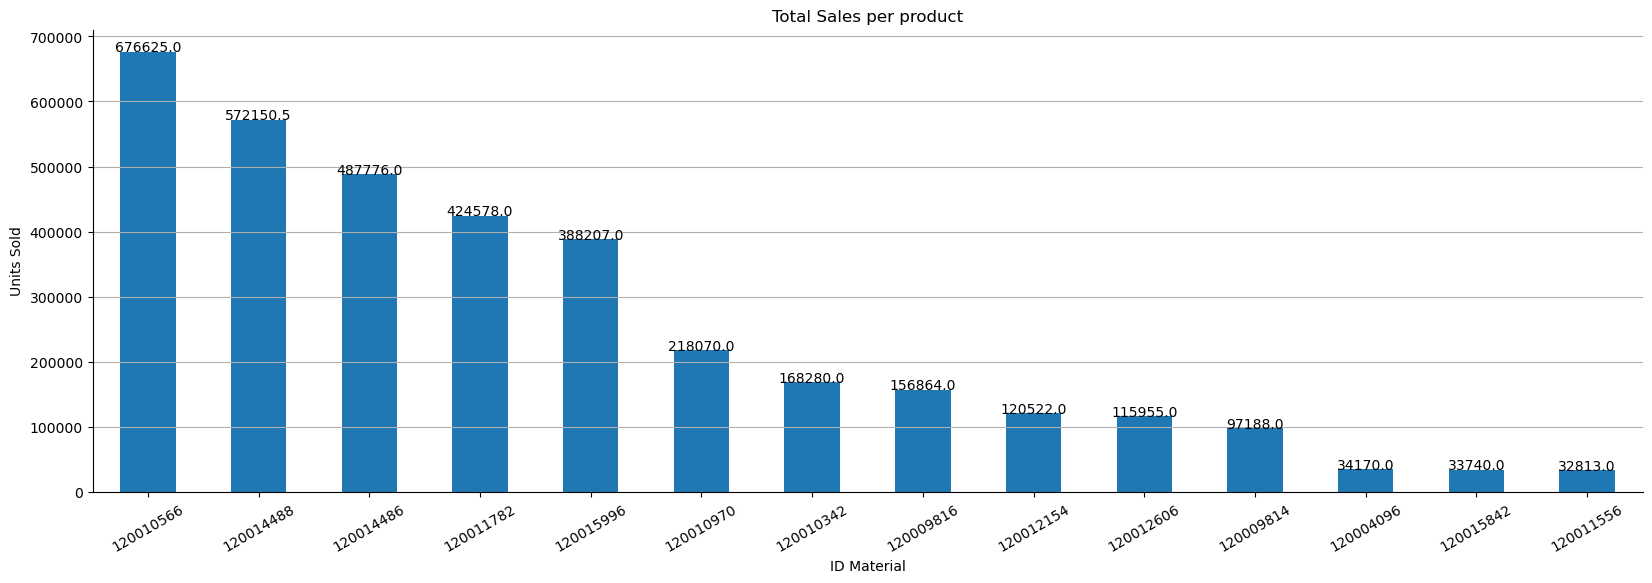

In [118]:
#total units sold per ID
units_sold = df.groupby('ID_material')['Units'].sum()

#descending order
units_sold = units_sold.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 6)) 
units_sold.plot(kind='bar', ax=ax)

plt.xlabel('ID Material')
plt.ylabel('Units Sold')
plt.title('Total Sales per product')
plt.xticks(rotation=30)
plt.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, v in enumerate(units_sold):
    ax.text(i, v + 10, str(v), ha='center')    #number for each bar

plt.show()

In [119]:
#mean, median, mode, and standard deviation
summary_stats = df.groupby('ID_material')['Units'].agg(['mean', 'median', lambda x: x.mode().values[0], 'std'])

summary_stats.rename(columns={'<lambda_0>': 'mode'}, inplace=True)

summary_stats

mean   median    mode          std
ID_material                                           
120004096     114.280936   120.00   120.0    88.076393
120009814     417.115880   312.00   156.0   312.520550
120009816     645.530864   576.00     0.0   552.543953
120010342     728.484848   720.00   780.0   408.026905
120010566    3103.784404  2856.00     0.0  1695.641111
120010970    1172.419355  1020.00   780.0   740.315715
120011556     209.000000   174.00    90.0   164.709145
120011782    2573.200000  2436.00  2604.0   594.872842
120012154     873.347826   675.00   360.0   657.840835
120012606     982.669492   560.00   280.0   949.946846
120014486    1868.873563  1890.00  1512.0  1142.954520
120014488    2134.889925  1811.25     0.0  1742.106046
120015842     337.400000   320.00   120.0   206.767424
120015996    1617.529167  1506.00   296.0   898.032399

# Exploring Time Series

## ACF & PACF

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


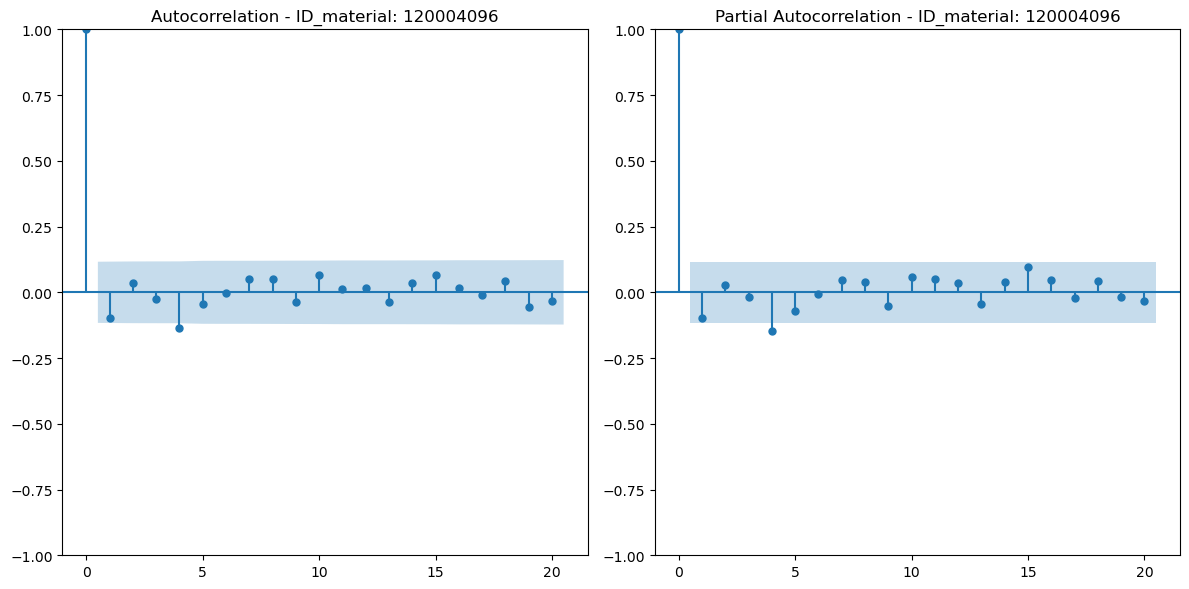

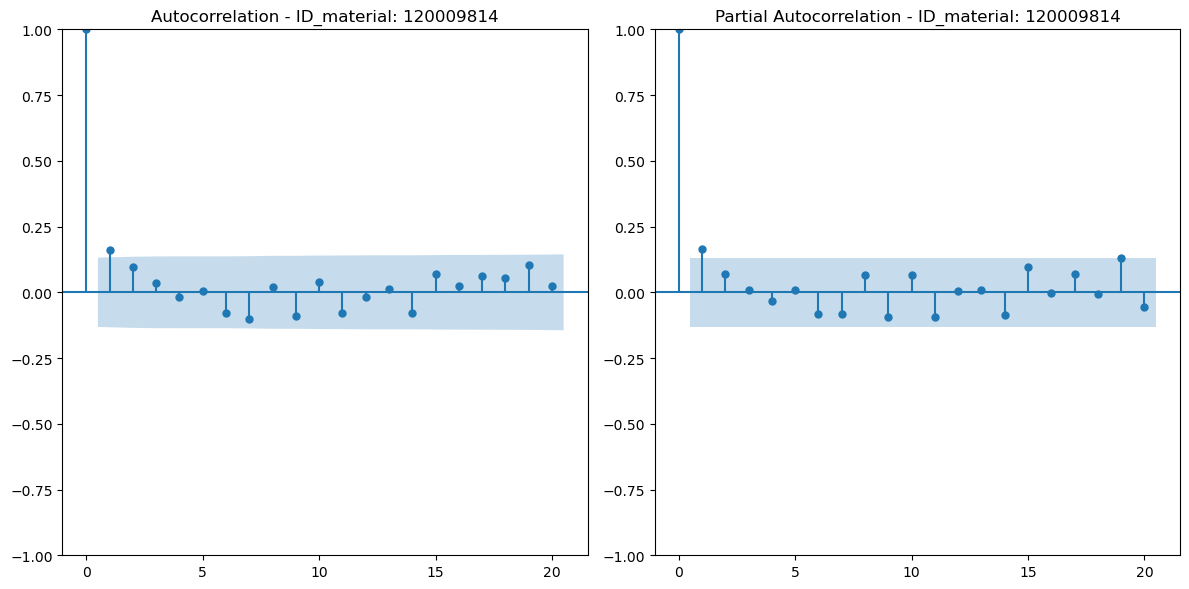

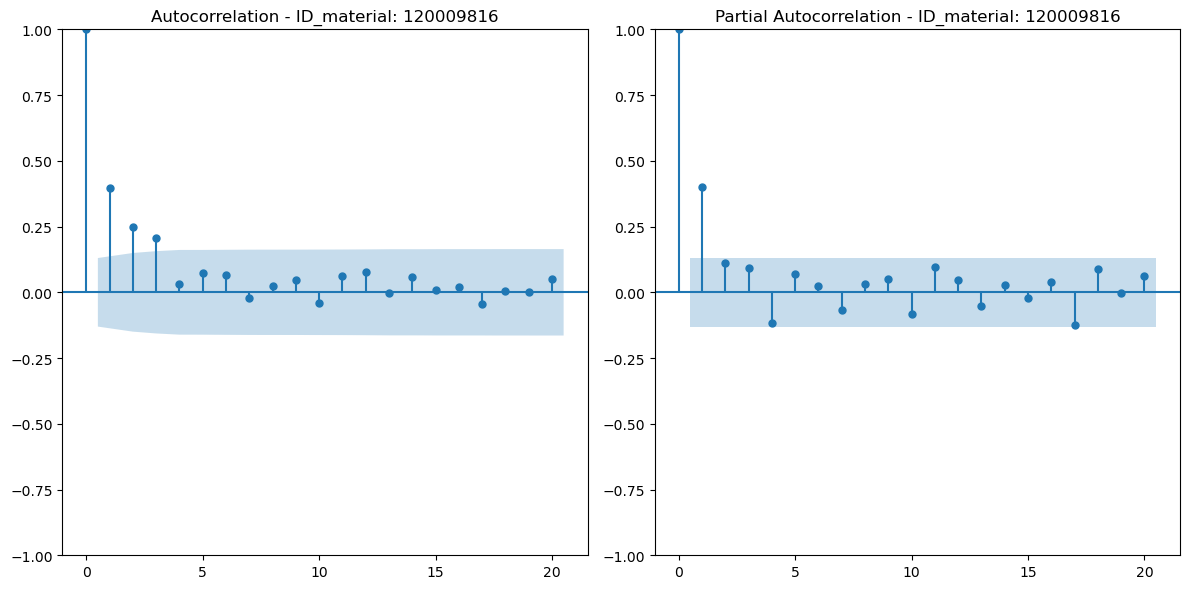

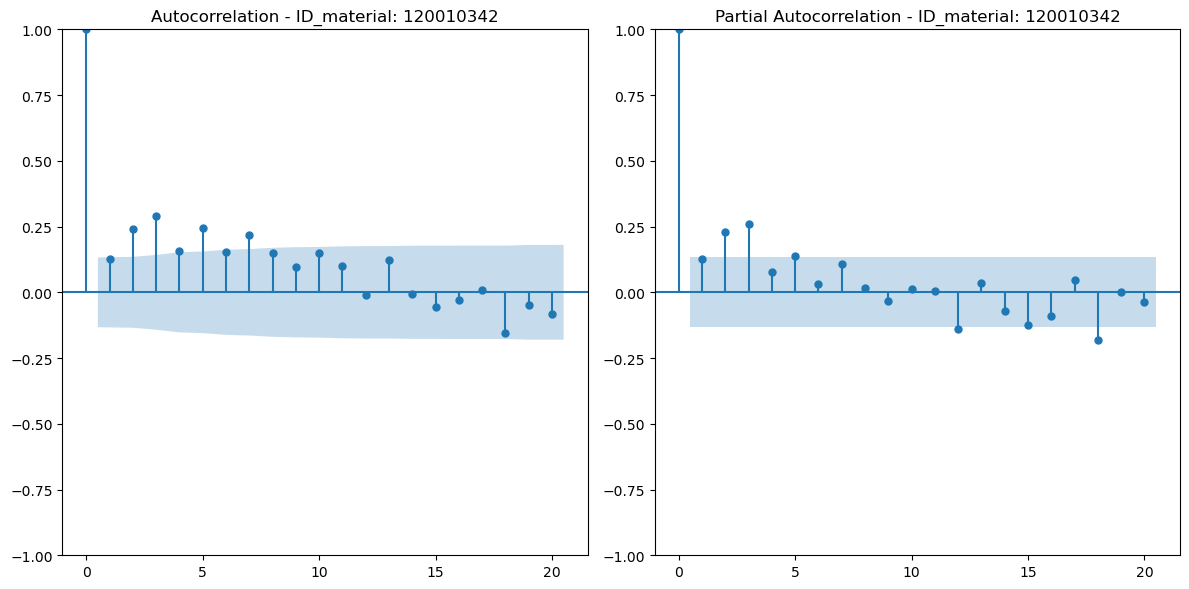

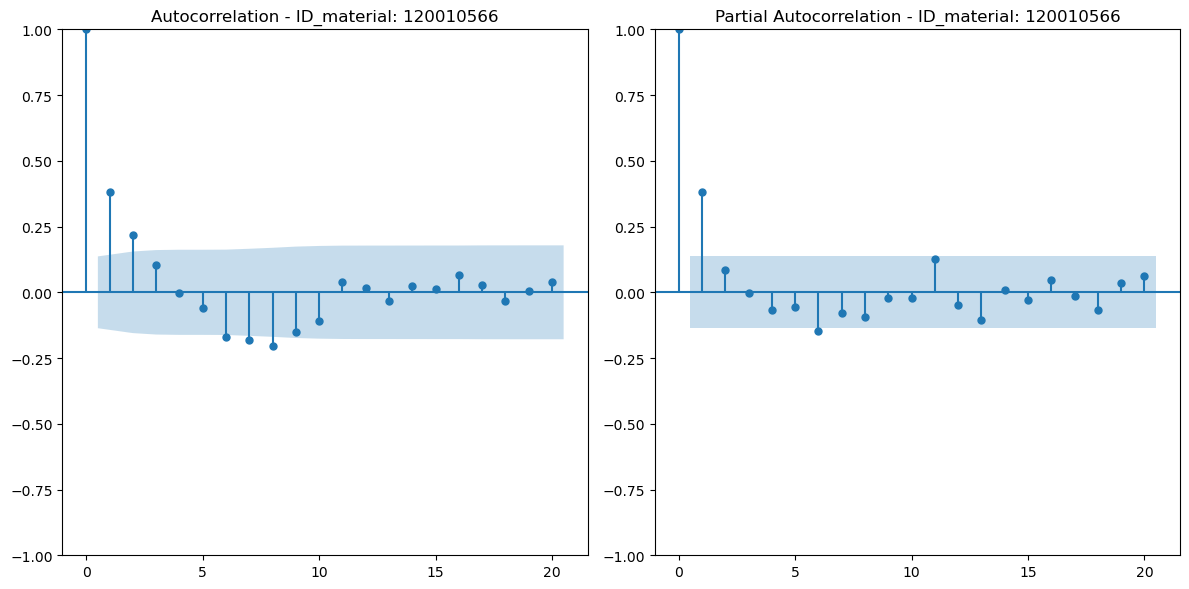

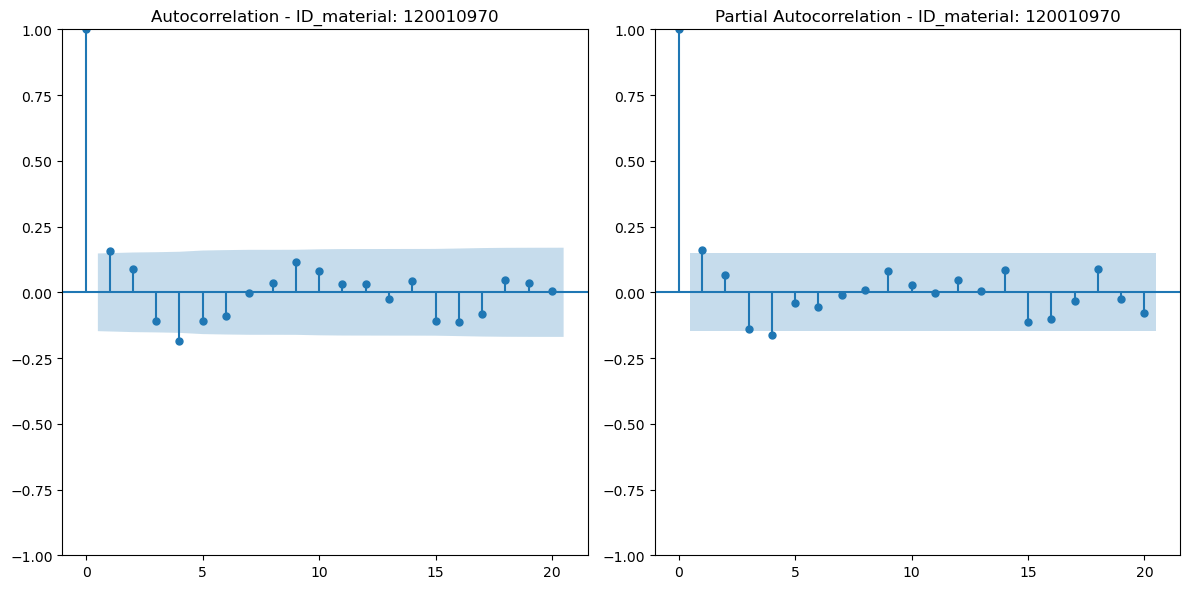

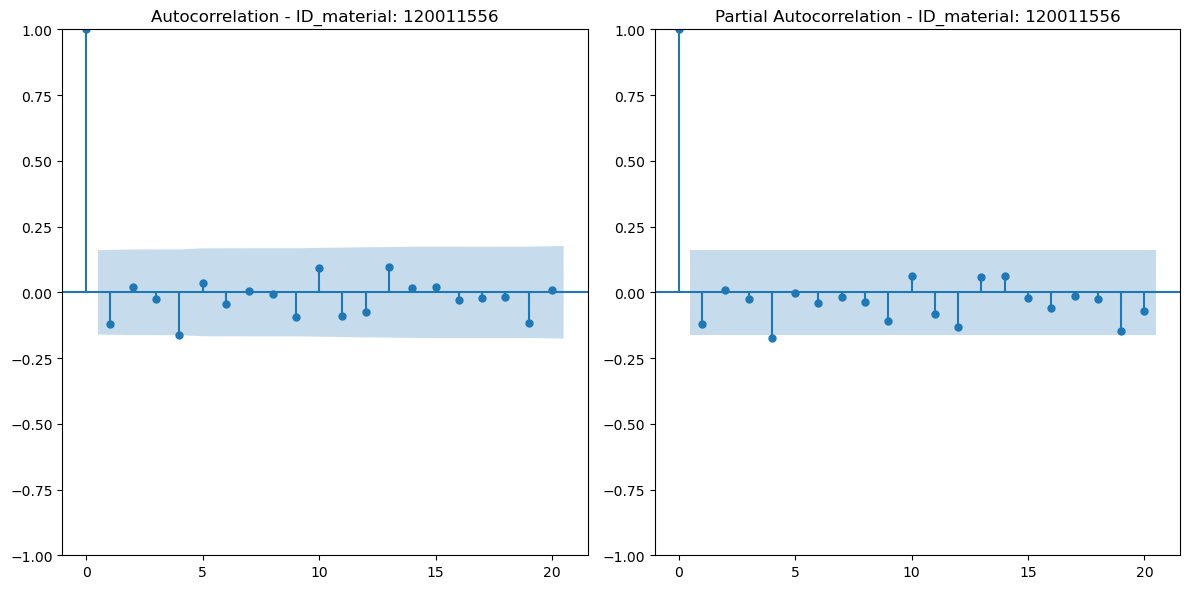

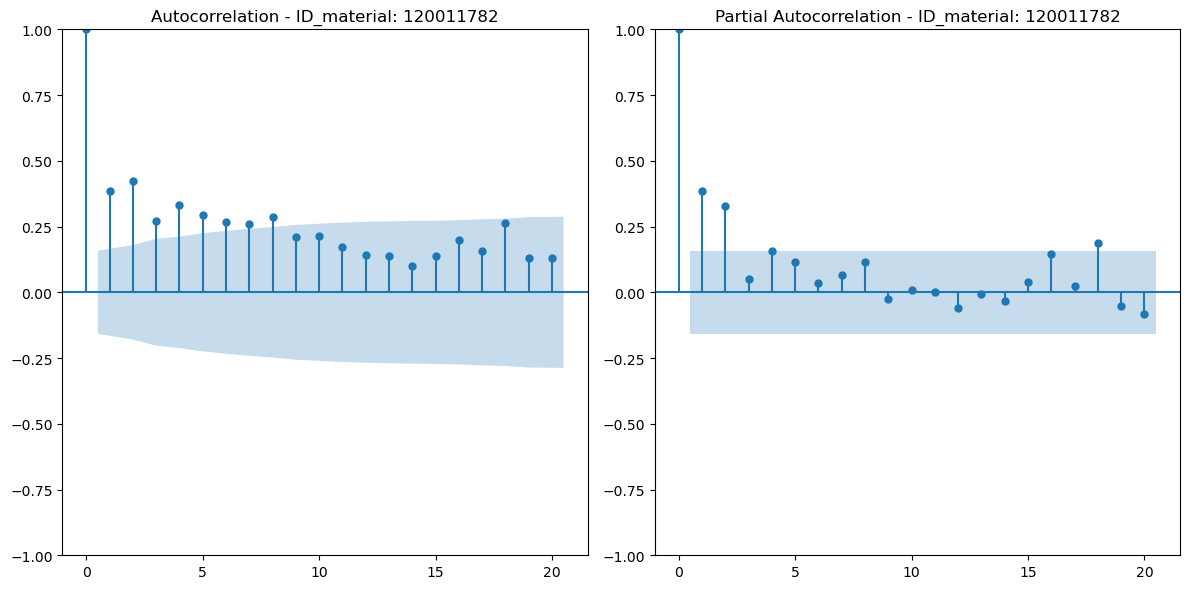

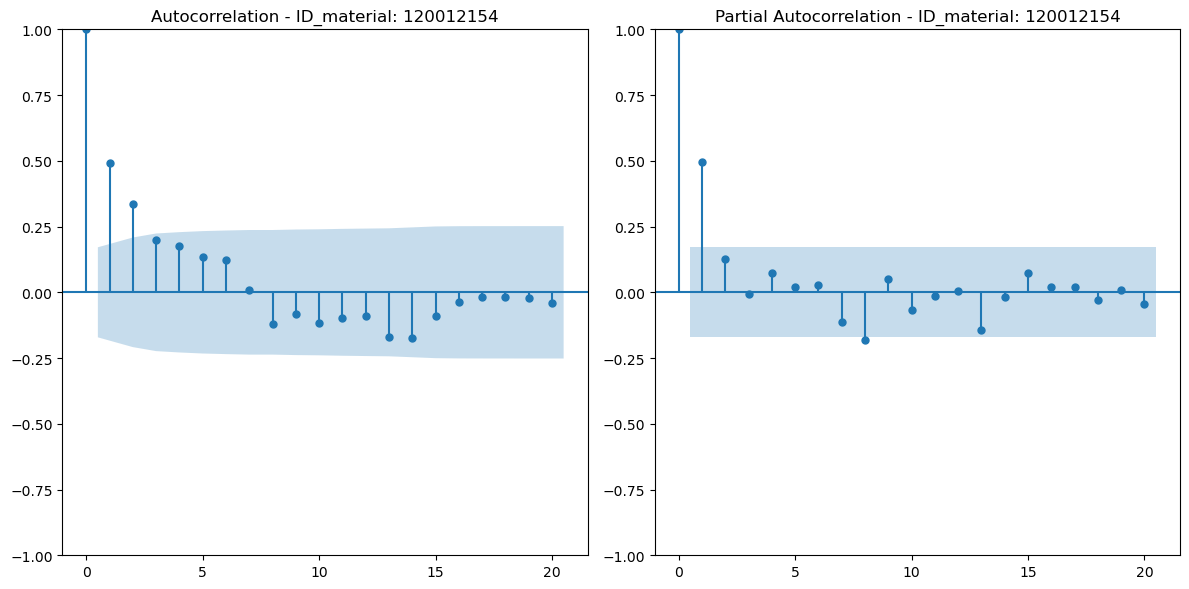

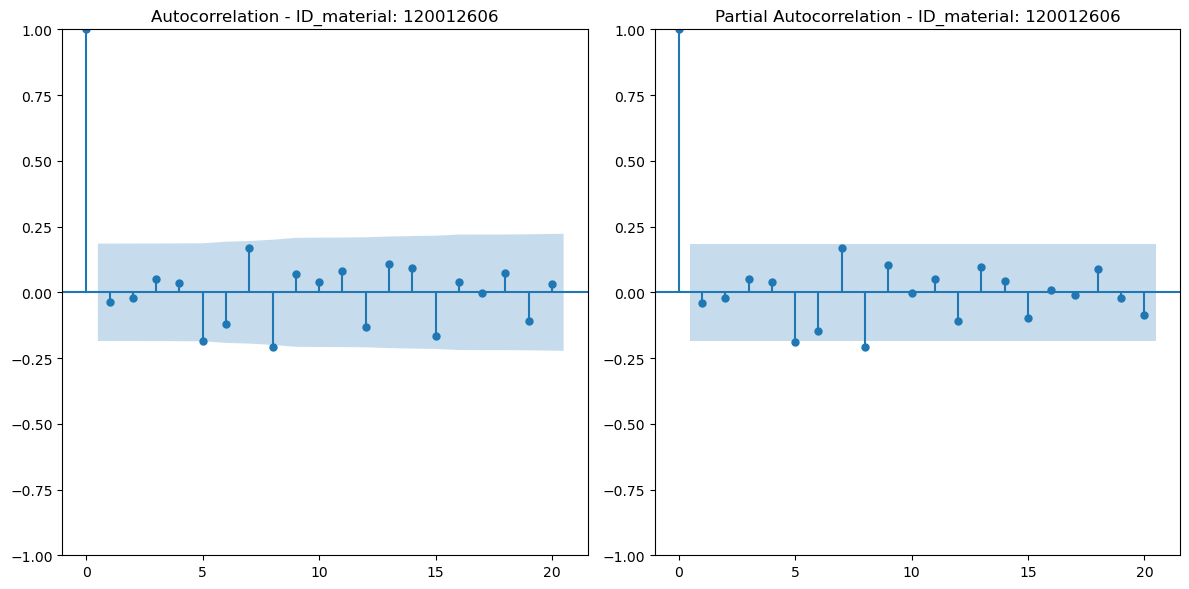

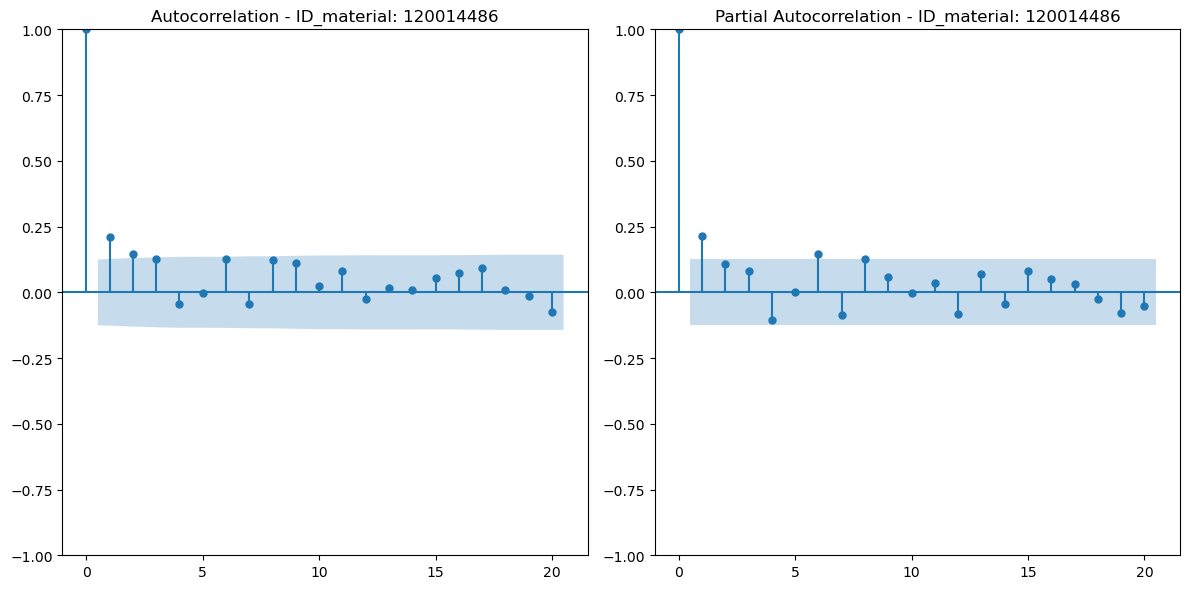

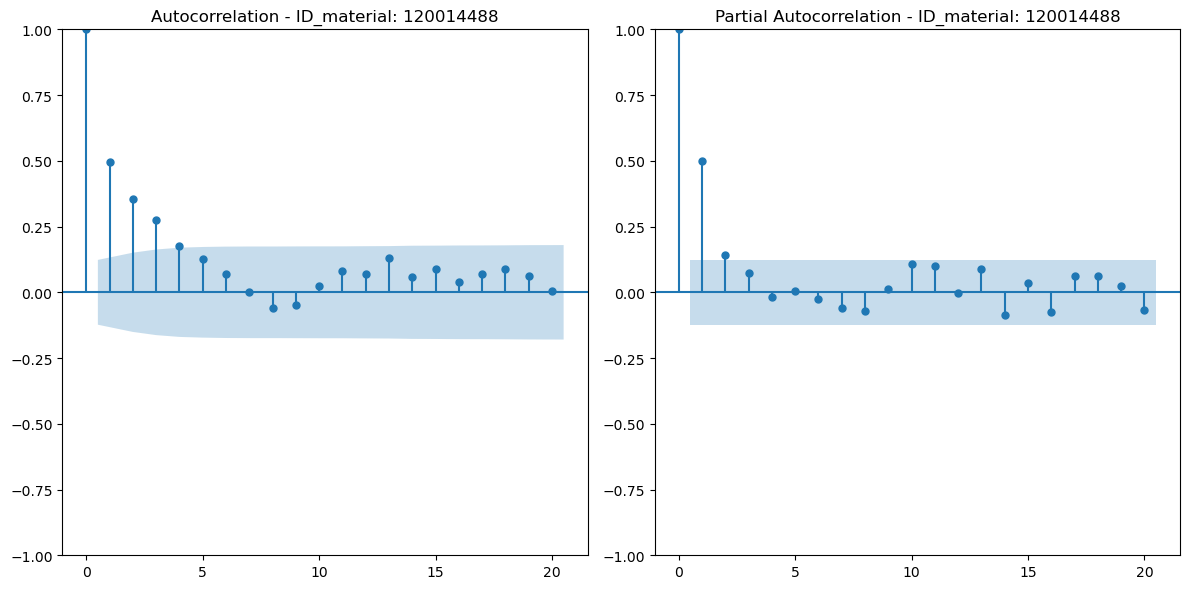

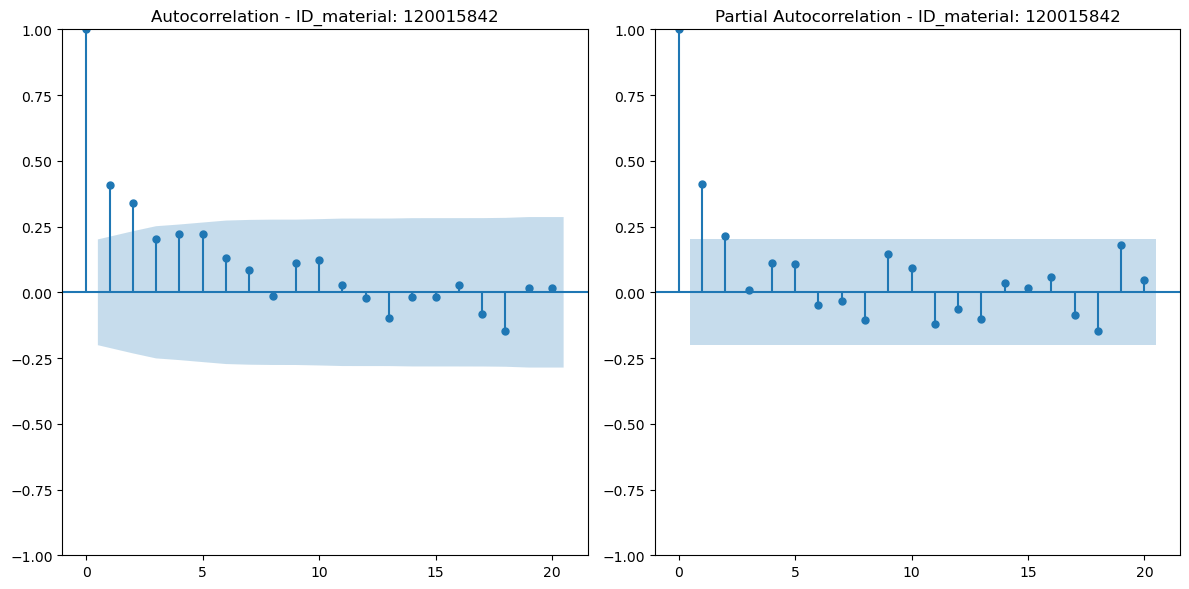

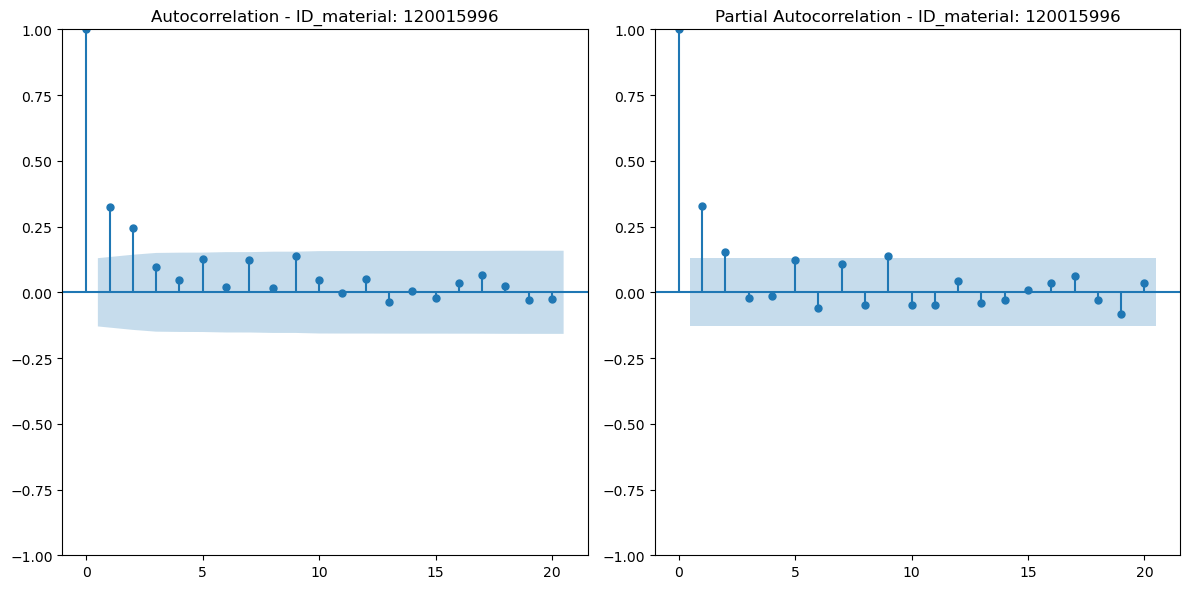

In [120]:
grouped = df.groupby('ID_material')

for group_name, group_data in grouped:
    group_data = group_data[group_data['Units'] < group_data['Units'].quantile(0.95)]  #remove outliers above the 95th percentile


    #ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(group_data['Units'], lags=20, ax=plt.gca())
    plt.title(f'Autocorrelation - ID_material: {group_name}')

    #PACF
    lag_pacf = pacf(group_data['Units'], nlags=20, method='ywm') 
    plt.subplot(122)
    plot_pacf(group_data['Units'], lags=20, ax=plt.gca())
    plt.title(f'Partial Autocorrelation - ID_material: {group_name}')

    plt.tight_layout()
    plt.show()

## Stationarity

In [121]:
grouped_data = df.groupby('ID_material')

for group_name, group_data in grouped_data:
    print("ID Material:", group_name)
    
    result = adfuller(group_data['Units'])  #stationarity test
    
    test_statistic = result[0]
    p_value = result[1]
        
    if p_value < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    
    print("________________________________________")

ID Material: 120004096
The time series is stationary.
________________________________________
ID Material: 120009814
The time series is stationary.
________________________________________
ID Material: 120009816
The time series is stationary.
________________________________________
ID Material: 120010342
The time series is stationary.
________________________________________
ID Material: 120010566
The time series is stationary.
________________________________________
ID Material: 120010970
The time series is stationary.
________________________________________
ID Material: 120011556
The time series is stationary.
________________________________________
ID Material: 120011782
The time series is non-stationary.
________________________________________
ID Material: 120012154
The time series is stationary.
________________________________________
ID Material: 120012606
The time series is stationary.
________________________________________
ID Material: 120014486
The time series is stat

## Monthly Seasonal Decompose

In [122]:
df.set_index('year_week', inplace=True)

### ID = 120010970

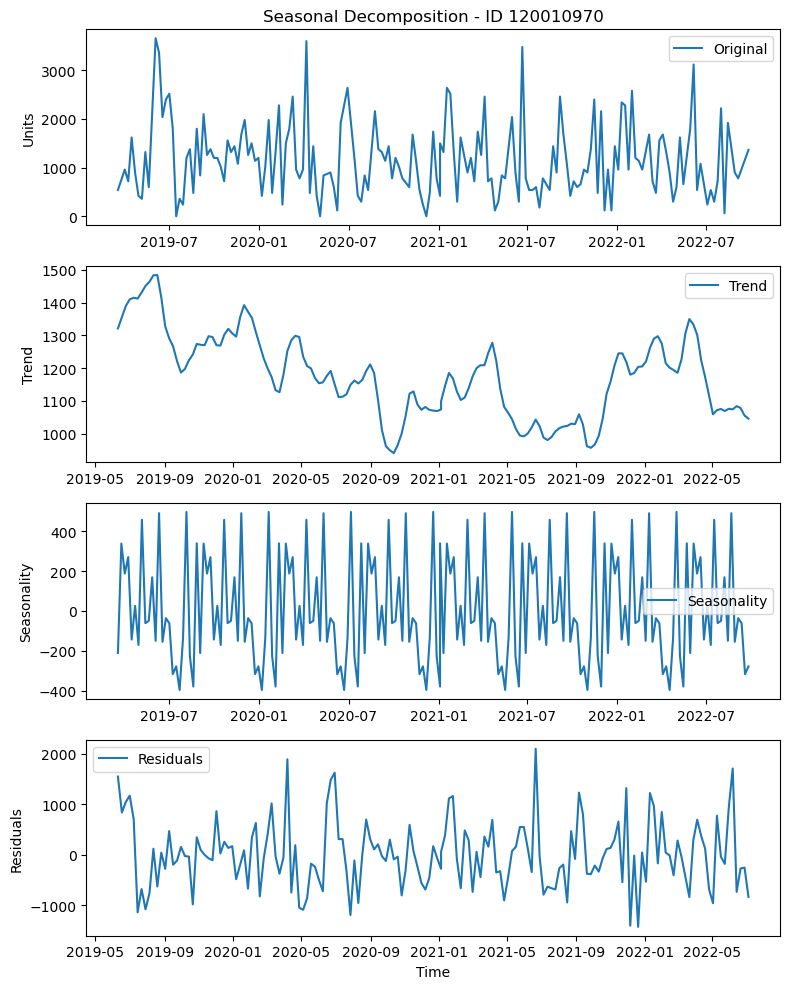

In [123]:
ts = df[df['ID_material'] == 120010970]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120010970')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120012606

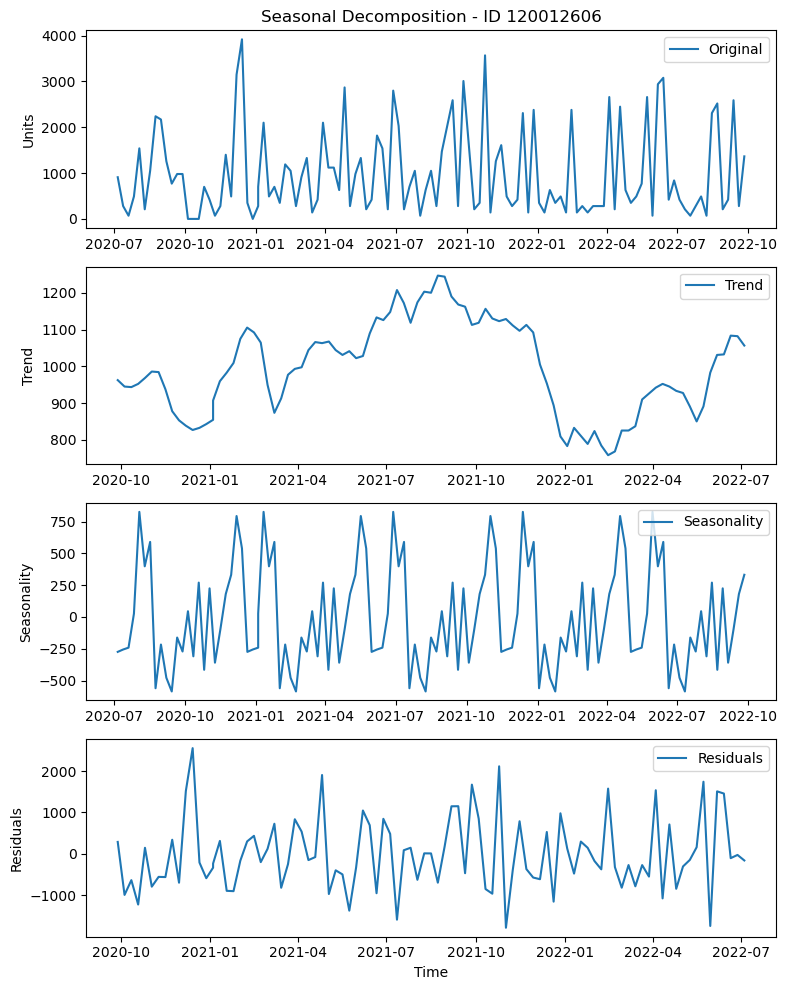

In [124]:
ts = df[df['ID_material'] == 120012606]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120012606')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120011556

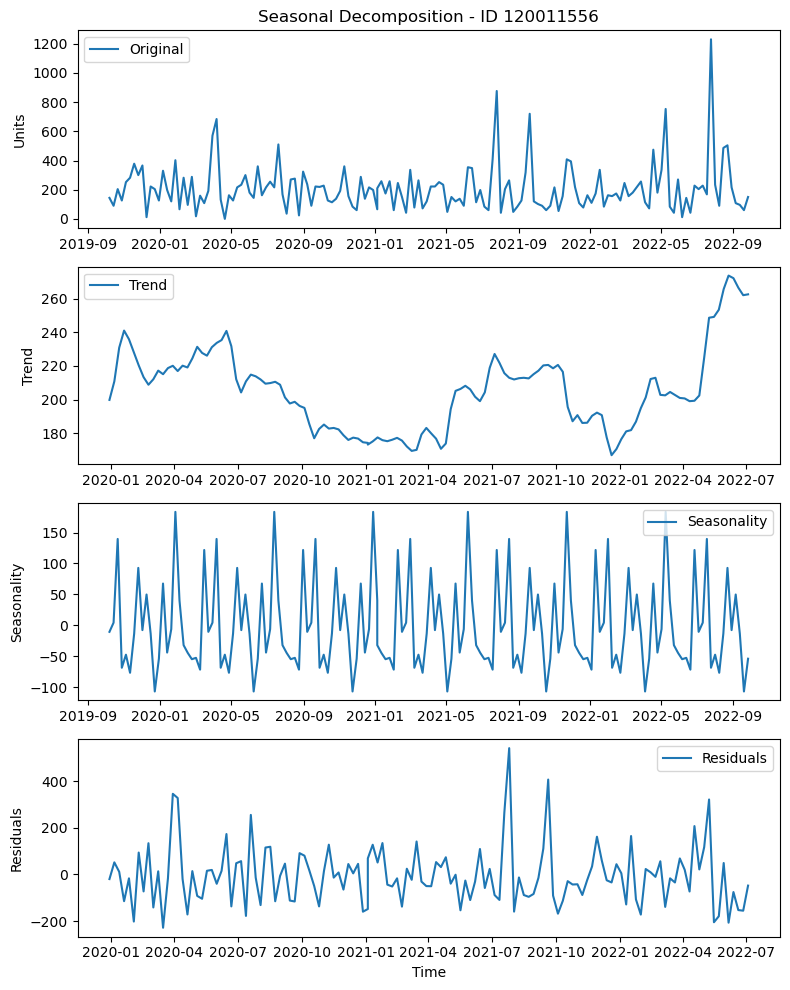

In [125]:
ts = df[df['ID_material'] == 120011556]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120011556')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120010566

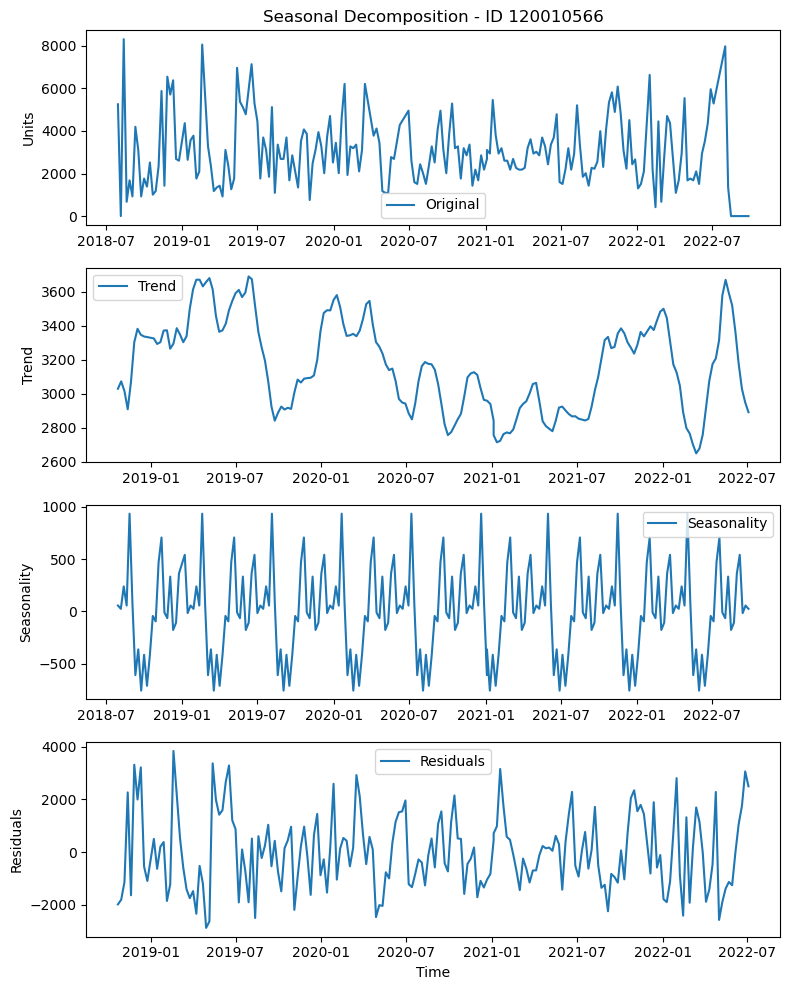

In [126]:
ts = df[df['ID_material'] == 120010566]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120010566')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120010342

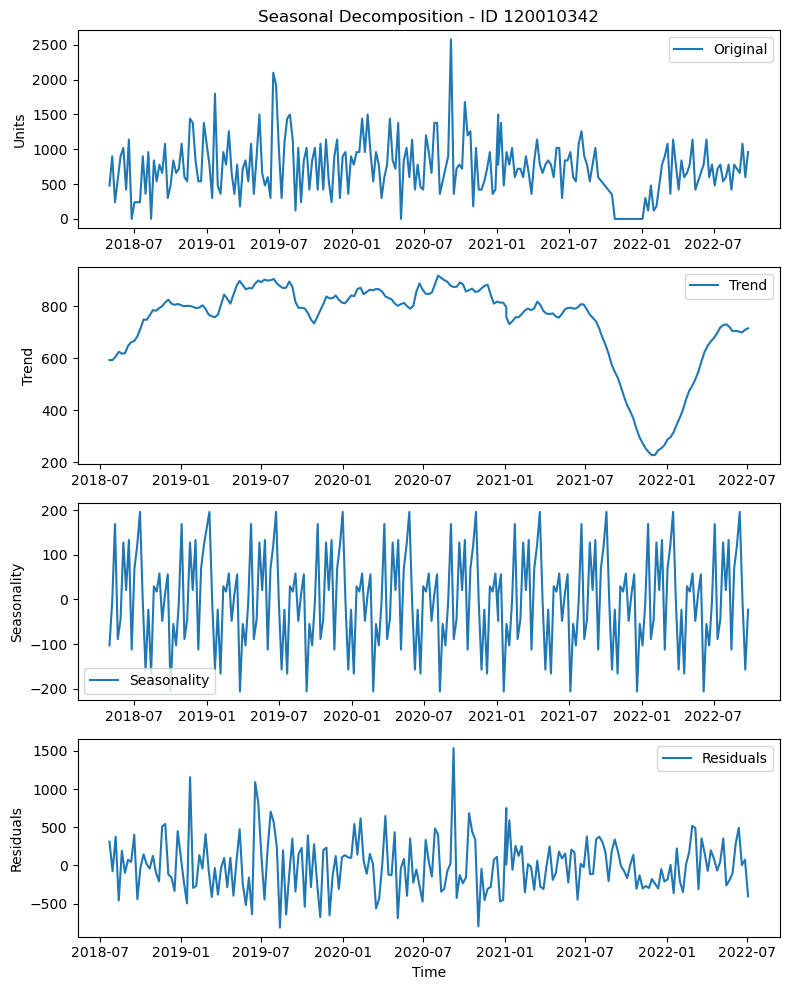

In [127]:
ts = df[df['ID_material'] == 120010342]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120010342')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120009814

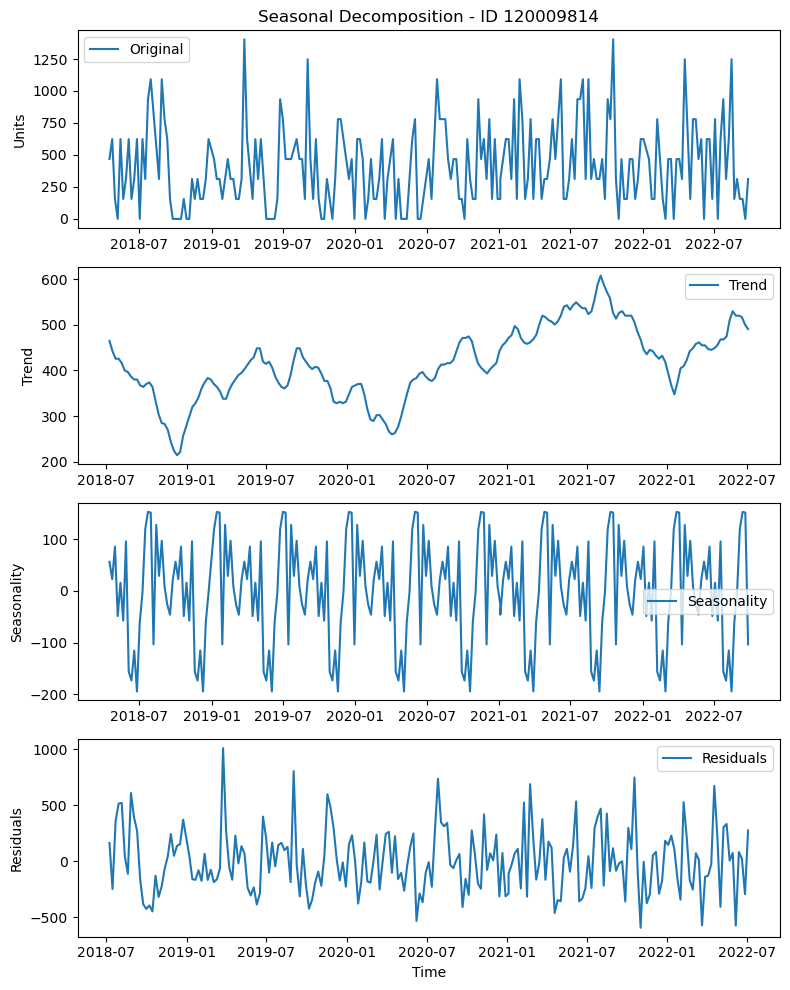

In [128]:
ts = df[df['ID_material'] == 120009814]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120009814')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120012154

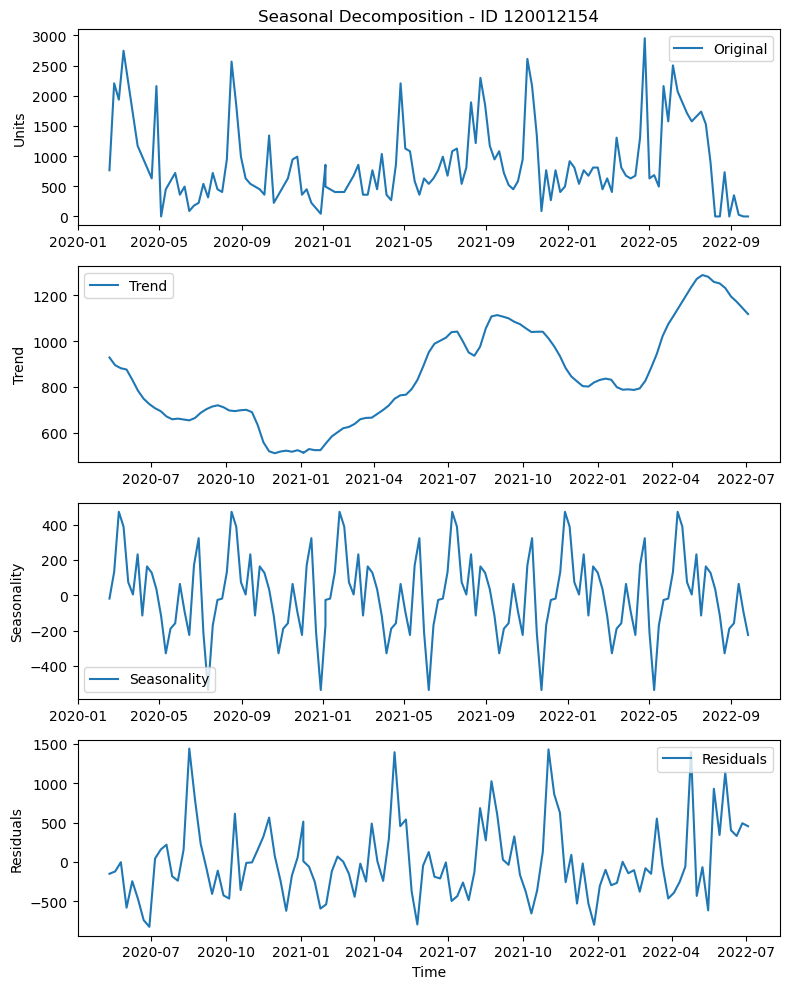

In [129]:
ts = df[df['ID_material'] == 120012154]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120012154')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120004096

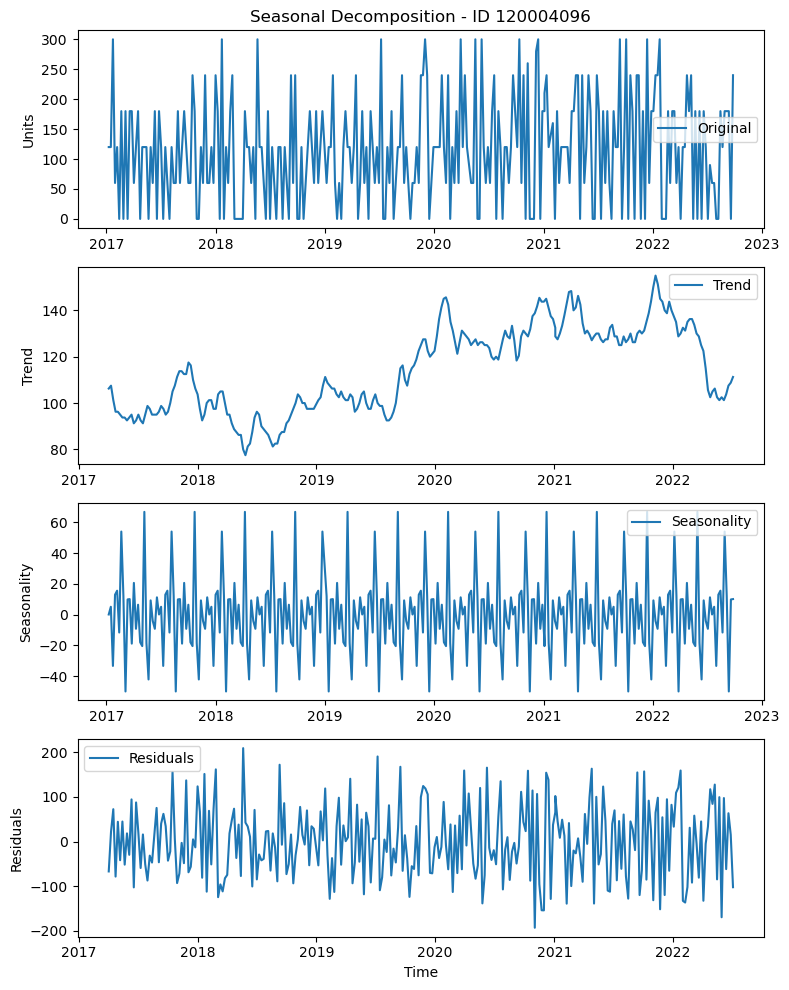

In [130]:
ts = df[df['ID_material'] == 120004096]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120004096')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120009816

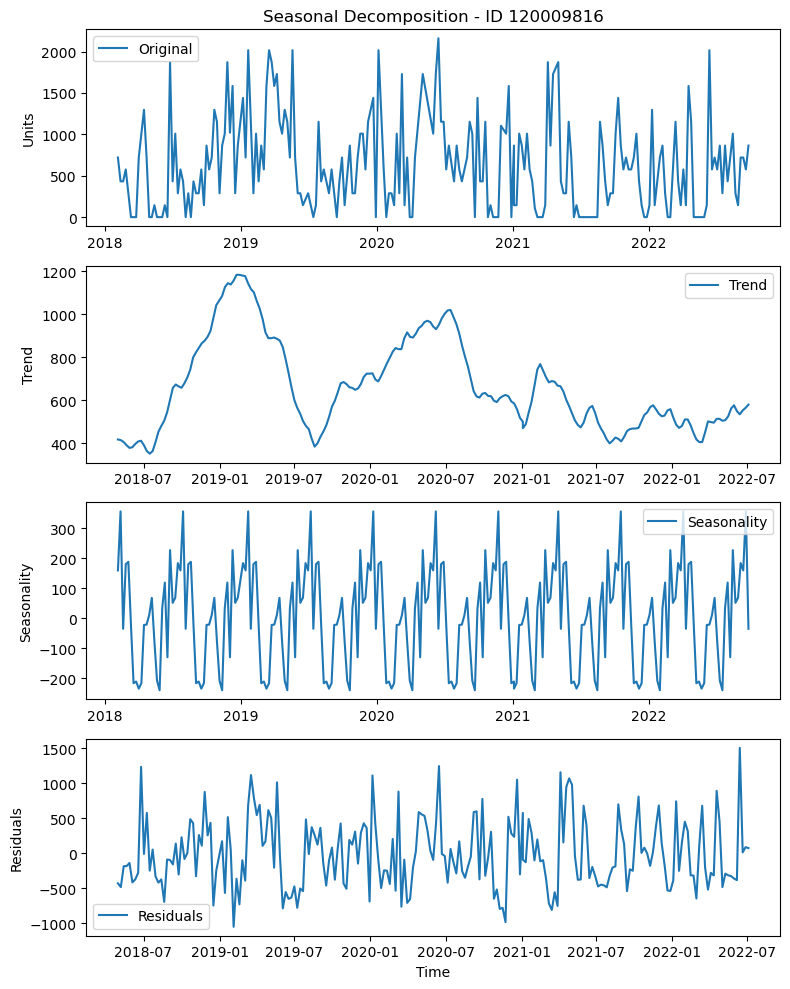

In [131]:
ts = df[df['ID_material'] == 120009816]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120009816')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120011782

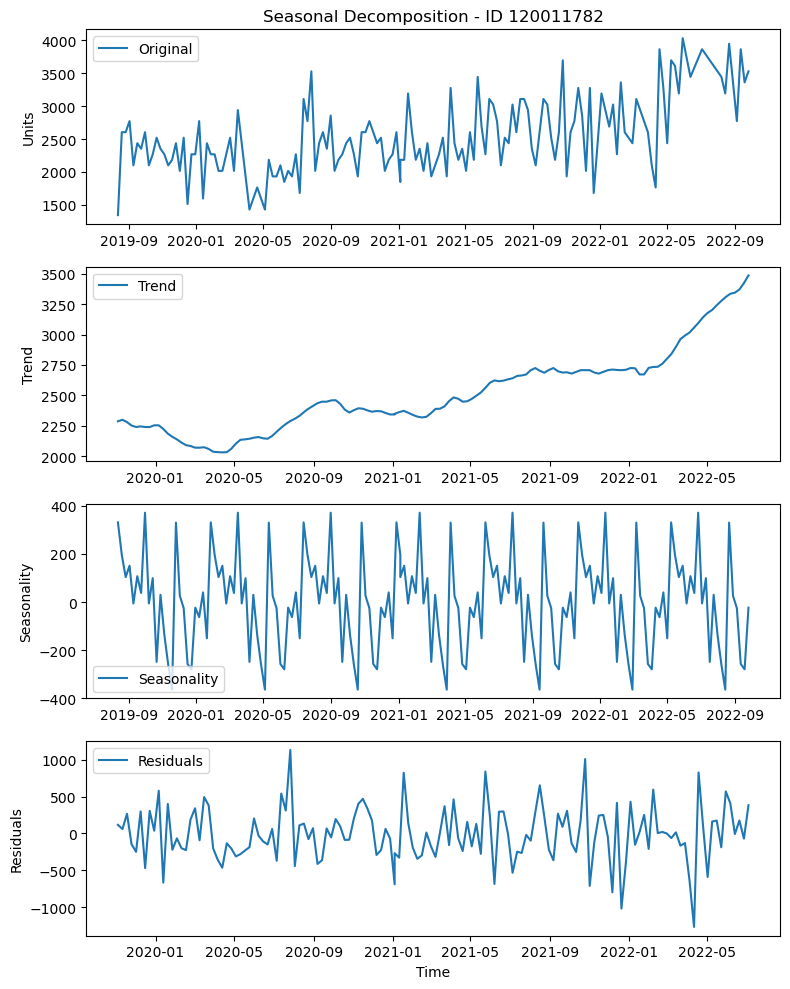

In [132]:
ts = df[df['ID_material'] == 120011782]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120011782')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120014486

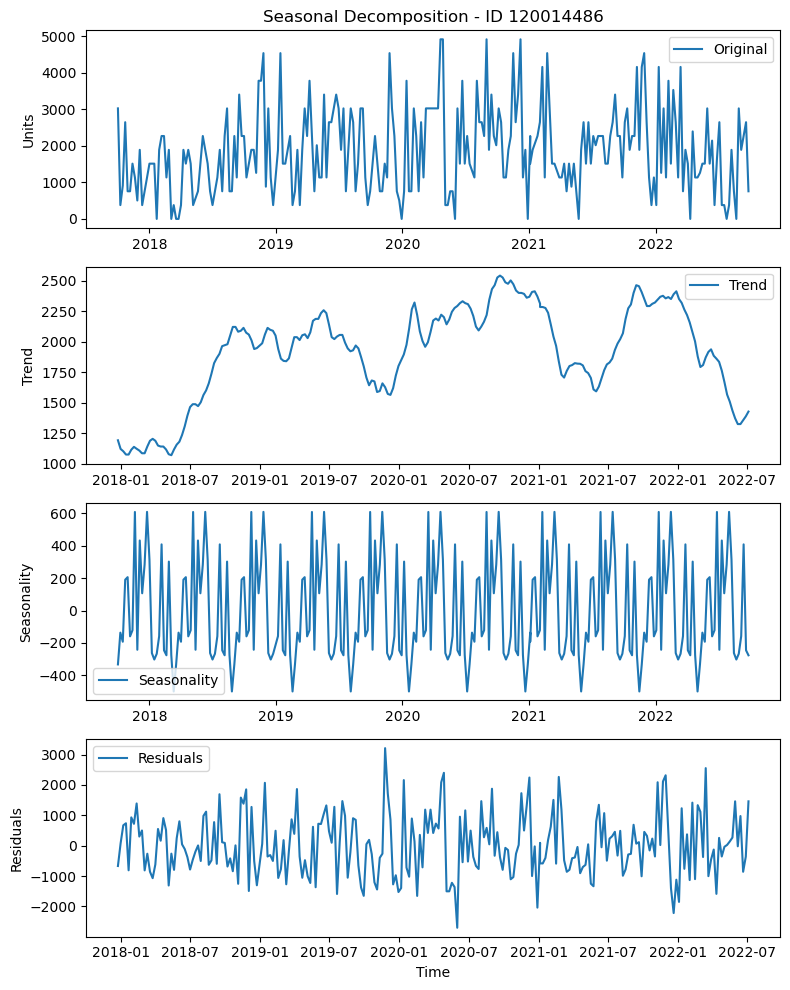

In [133]:
ts = df[df['ID_material'] == 120014486]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120014486')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120014488

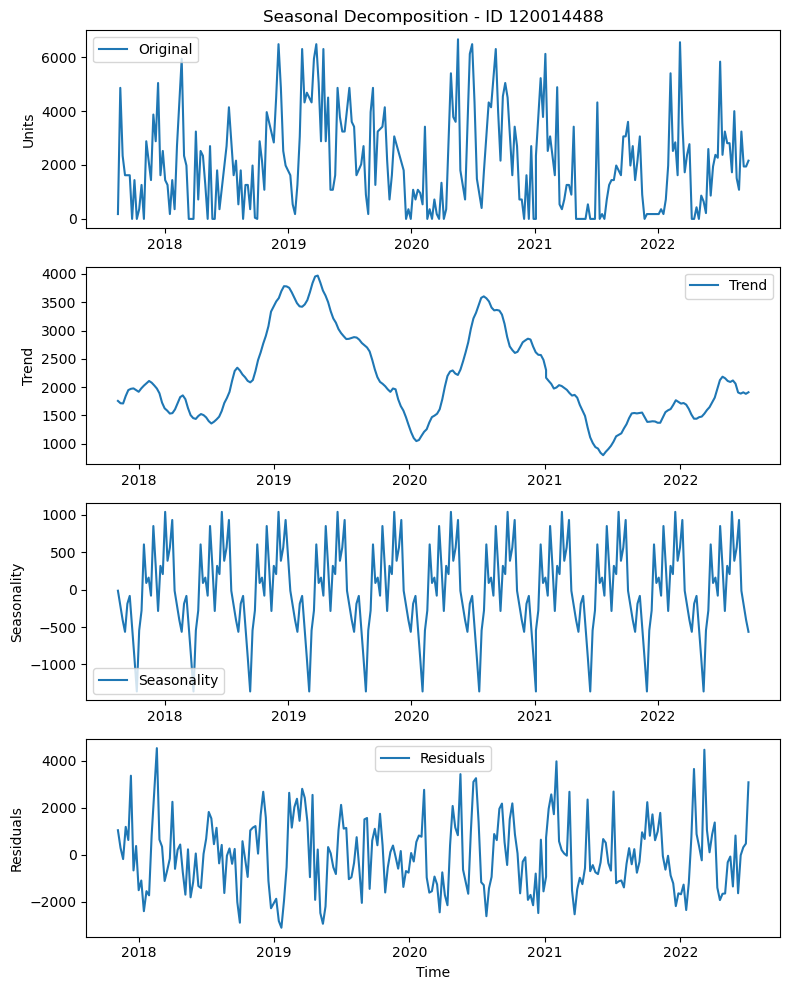

In [134]:
ts = df[df['ID_material'] == 120014488]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120014488')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120015996

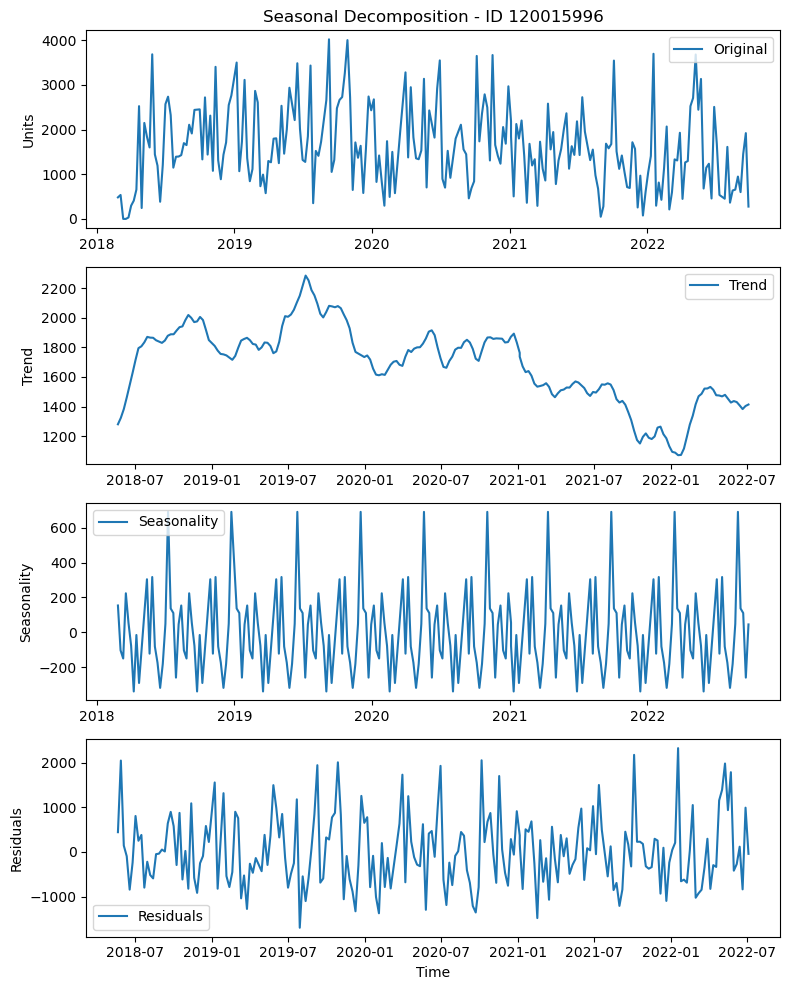

In [135]:
ts = df[df['ID_material'] == 120015996]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120015996')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

### ID = 120015842

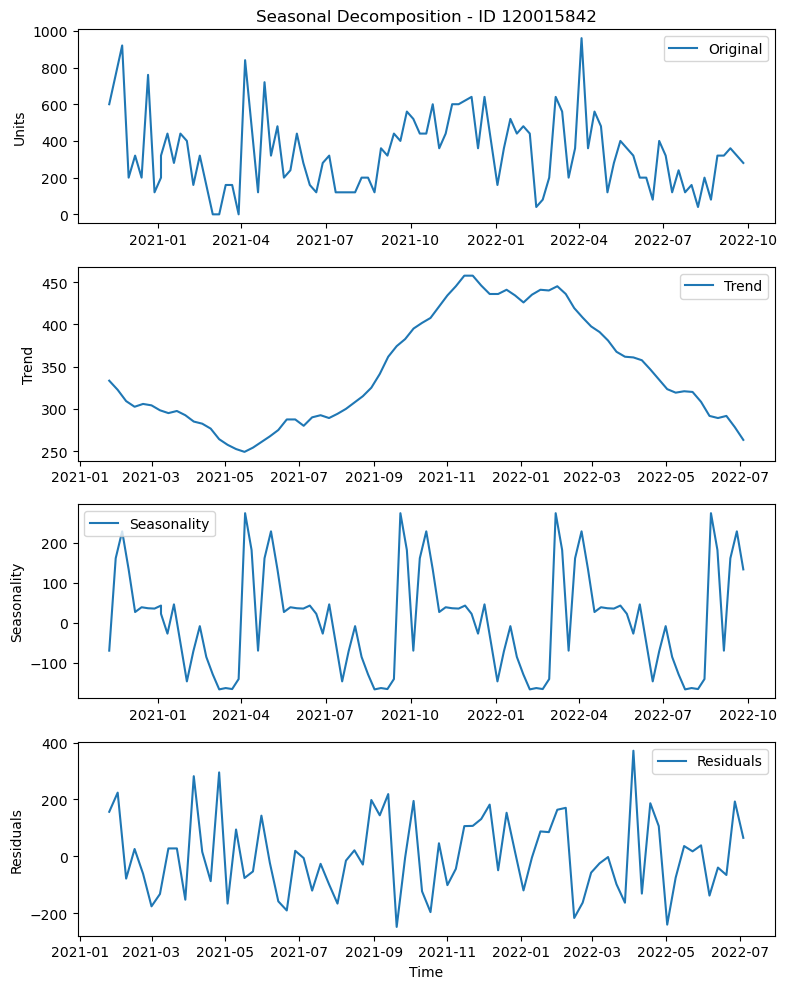

In [136]:
ts = df[df['ID_material'] == 120015842]['Units']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts, model='additive', period=24)  # Assuming 52 weeks in a year

# Plot the decomposition components
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
ax[0].plot(ts, label='Original')
ax[0].set_ylabel('Units')
ax[0].set_title(f'Seasonal Decomposition - ID 120015842')
ax[0].legend()
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_ylabel('Trend')
ax[1].legend()
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_ylabel('Seasonality')
ax[2].legend()
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_ylabel('Residuals')
ax[3].set_xlabel('Time')
ax[3].legend()

plt.tight_layout()
plt.show()

# SARIMA MODEL

In [137]:
df.reset_index(inplace=True)

## ID = 120010970

In [138]:
specific_id = 120010970 #ID and dates you want to work with

filtered_data = df[df['ID_material'] == specific_id]  #Filter the data for the specific ID

filtered_data.set_index('year_week', inplace=True)

In [139]:
#split the data into train and test sets
train_data = filtered_data.iloc[:-8]  #all data except the last 8 weeks for training
test_data = filtered_data.iloc[-8:]   #last 8 weeks for testing

#fit the ARIMA model on the training date
model = ARIMA(train_data['Units'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 52))  #we have been changing this manually to achieve the best result for each ID
model_fit = model.fit()

#forecast for the next 8 weeks/ 2 months in the test data
forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index  #assign the new index to the forecasted values

#SMAPE for test
smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

#SMAPE for training
smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

#accuracy measures
print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

#forecasted values
print("Forecasted Values:")
print(forecast)

Test SMAPE: 43.24%
Train SMAPE: 58.49%
Forecasted Values:
2022-10-02    1421.548161
2022-10-09    1234.285585
2022-10-16    1190.366503
2022-10-23    1180.066069
2022-10-30    1177.650287
2022-11-06    1177.083708
2022-11-13    1176.950828
2022-11-20    1176.919663
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

### Actual Sales vs Forecast 2022

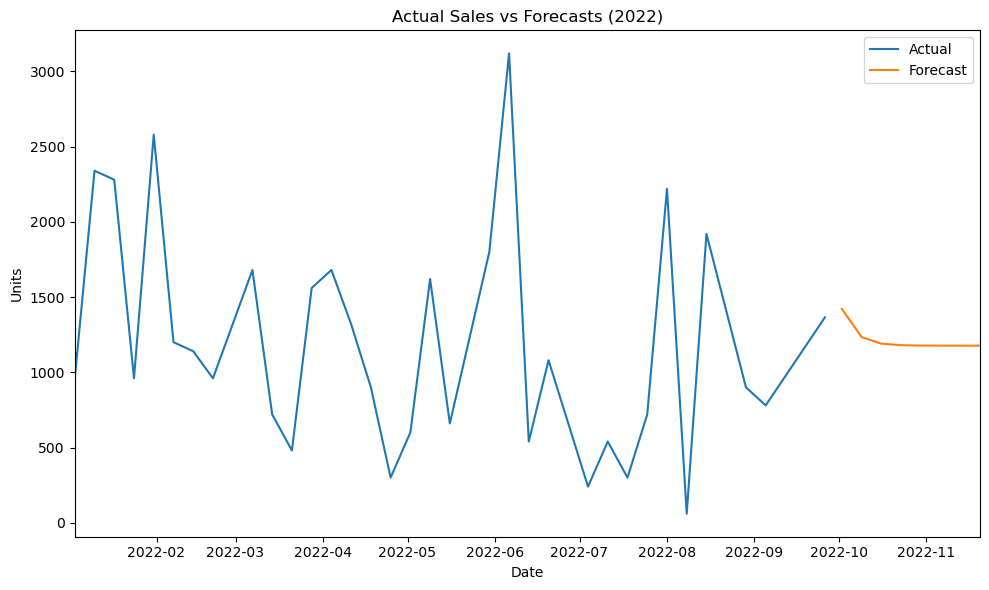

In [140]:
#data for 2022
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120012606

In [141]:
specific_id = 120012606

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [142]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variance

Test SMAPE: 81.86%
Train SMAPE: 93.61%
Forecasted Values:
2022-10-02     482.156162
2022-10-09    1410.846210
2022-10-16     964.597343
2022-10-23    1128.607164
2022-10-30    1146.482450
2022-11-06    1422.829309
2022-11-13     552.405710
2022-11-20    1182.187878
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

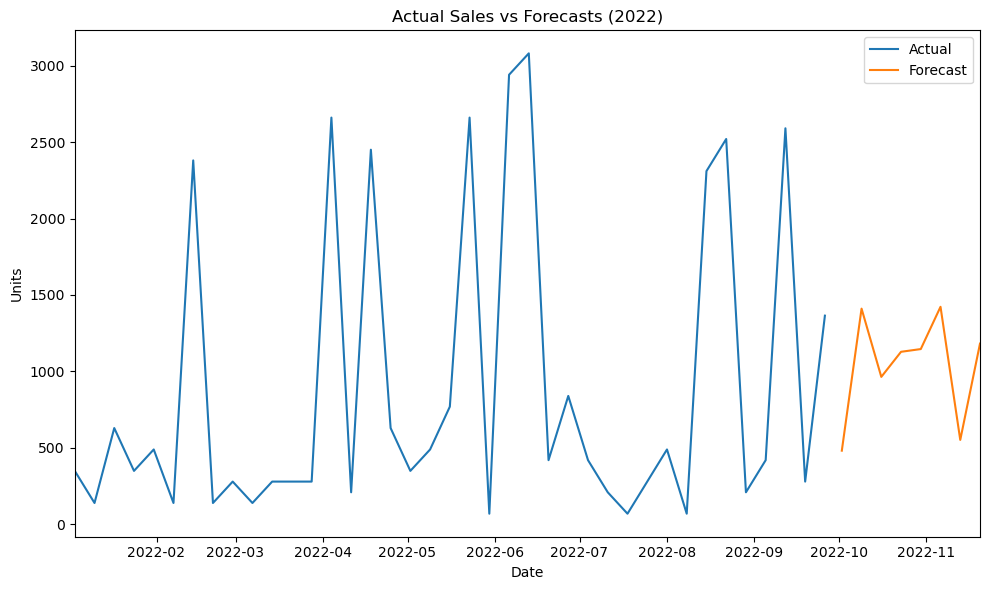

In [143]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120011556

In [144]:
specific_id = 120011556

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [145]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ARIMA(train_data['Units'], order=(1, 0, 1), seasonal_order=(1, 0, 0, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 65.37%
Train SMAPE: 35.49%
Forecasted Values:
2022-10-02    157.065101
2022-10-09    246.626449
2022-10-16    167.347377
2022-10-23    198.805609
2022-10-30    190.711556
2022-11-06    229.050485
2022-11-13    287.177767
2022-11-20    196.052227
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

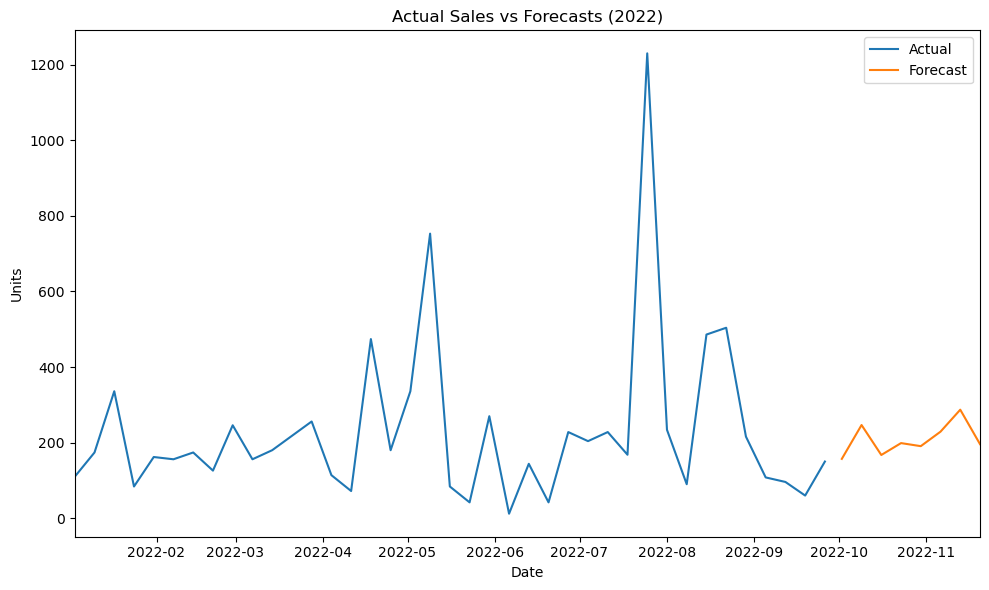

In [146]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120010566

In [147]:
specific_id = 120010566

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [148]:
train_data = filtered_data.iloc[:-8] 
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 189.80%
Train SMAPE: 76.53%
Forecasted Values:
2022-10-02    5241.322306
2022-10-09    3851.850221
2022-10-16    3234.257309
2022-10-23    3116.428764
2022-10-30    2977.128473
2022-11-06    3084.276663
2022-11-13    3071.361267
2022-11-20    3119.221016
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

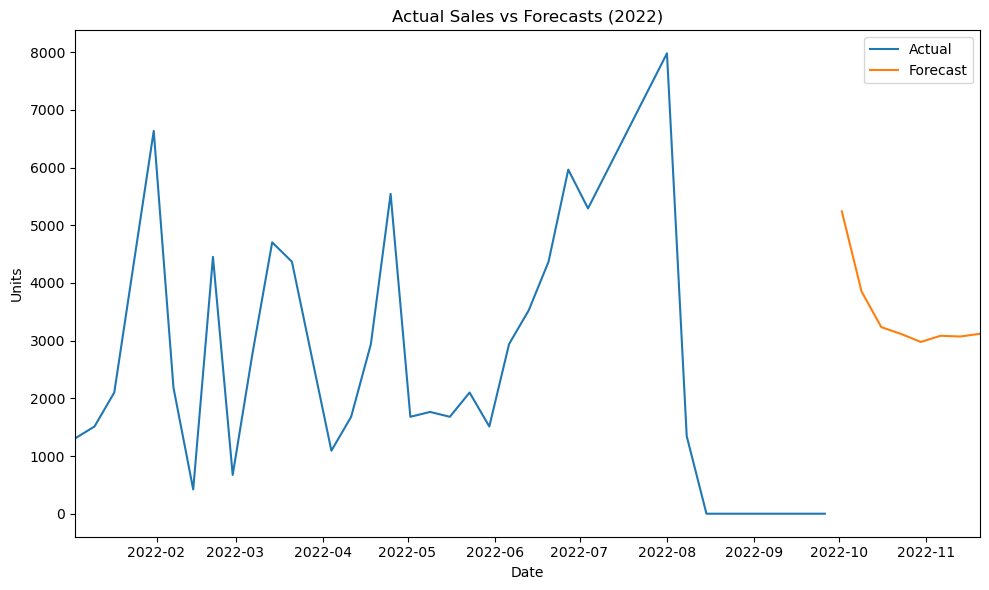

In [149]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120010342

In [152]:
specific_id = 120010342

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [154]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(1, 1, 2), seasonal_order=(0, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)
pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 22.59%
Train SMAPE: 42.91%
Forecasted Values:
2022-10-02    684.739693
2022-10-09    670.974859
2022-10-16    659.920730
2022-10-23    662.472628
2022-10-30    668.648128
2022-11-06    657.525998
2022-11-13    656.010801
2022-11-20    654.686660
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

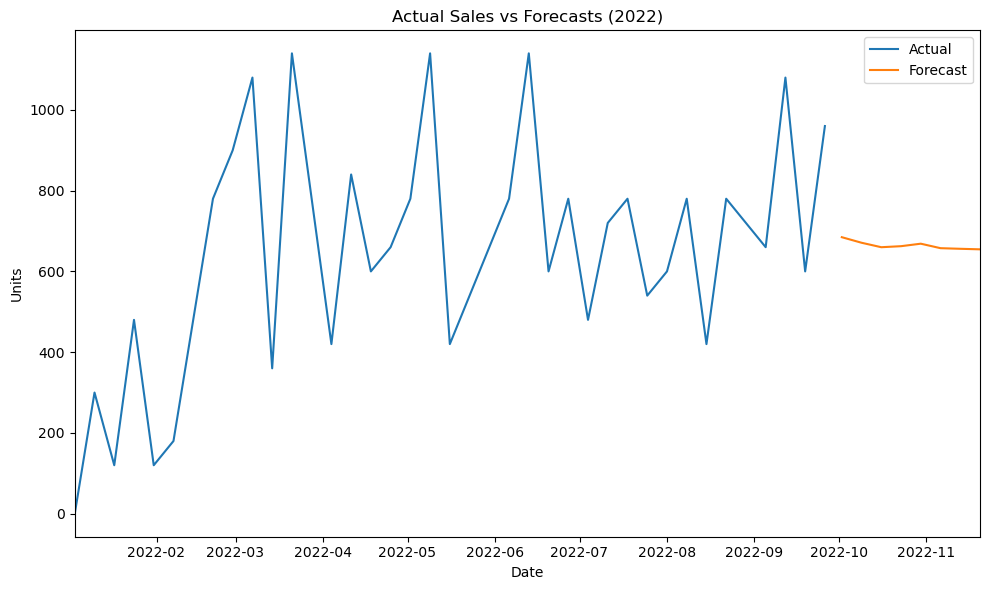

In [155]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120009814

In [159]:
specific_id = 120009814

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [160]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ARIMA(train_data['Units'], order=(0, 0, 0), seasonal_order=(0, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 81.30%
Train SMAPE: 67.08%
Forecasted Values:
2022-10-02    400.369329
2022-10-09    499.711761
2022-10-16    408.645904
2022-10-23    424.012933
2022-10-30    404.438895
2022-11-06    410.040196
2022-11-13    428.264410
2022-11-20    392.223018
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

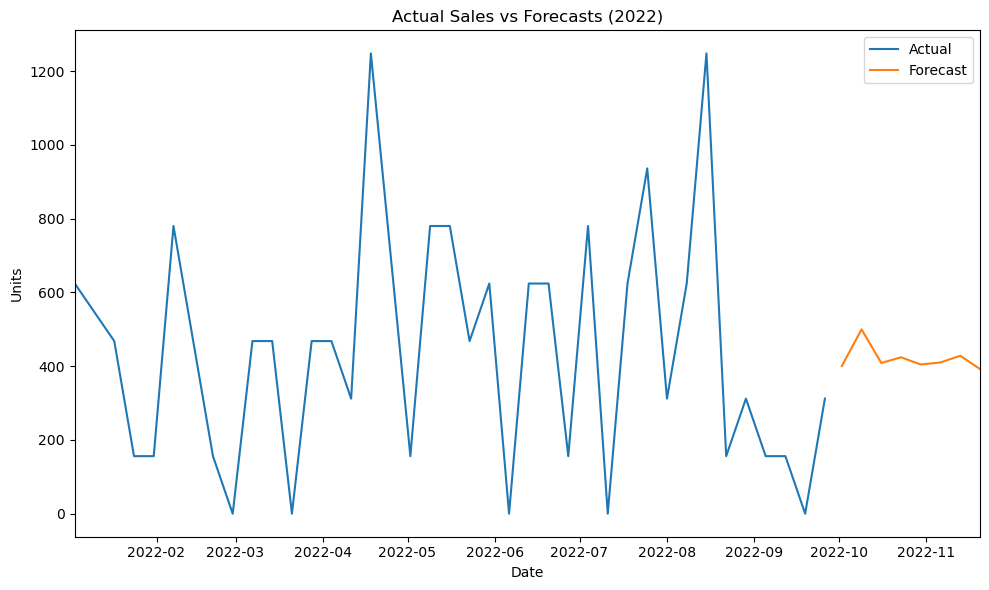

In [161]:
filtered_data_2022 = filtered_data.loc['2022']
plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120012154

In [162]:
specific_id = 120012154

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [165]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(0, 0, 0), seasonal_order=(0, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)
pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 166.79%
Train SMAPE: 50.06%
Forecasted Values:
2022-10-02    1057.669093
2022-10-09     940.482895
2022-10-16    1225.082578
2022-10-23    1141.152660
2022-10-30     993.486087
2022-11-06     944.989619
2022-11-13     977.570971
2022-11-20     900.847491
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variance

### Actual Sales vs Forecast 2022

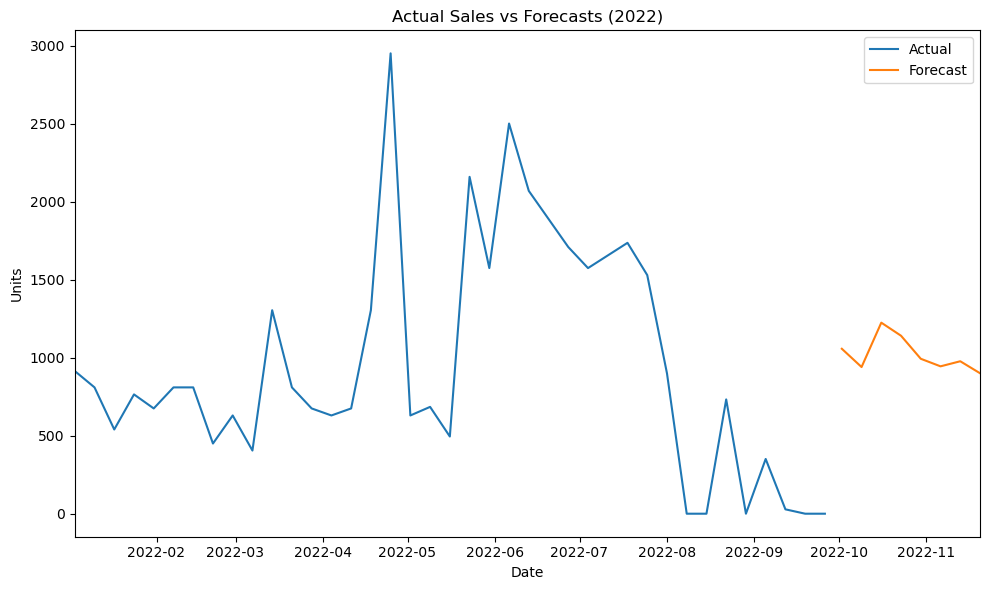

In [166]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120004096

In [167]:
specific_id = 120004096

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [168]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ARIMA(train_data['Units'], order=(0, 0, 0), seasonal_order=(1, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 81.96%
Train SMAPE: 77.25%
Forecasted Values:
2022-10-02    101.286744
2022-10-09    107.531136
2022-10-16    116.485362
2022-10-23    108.426388
2022-10-30    120.860966
2022-11-06    122.541086
2022-11-13    115.339254
2022-11-20    108.604392
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

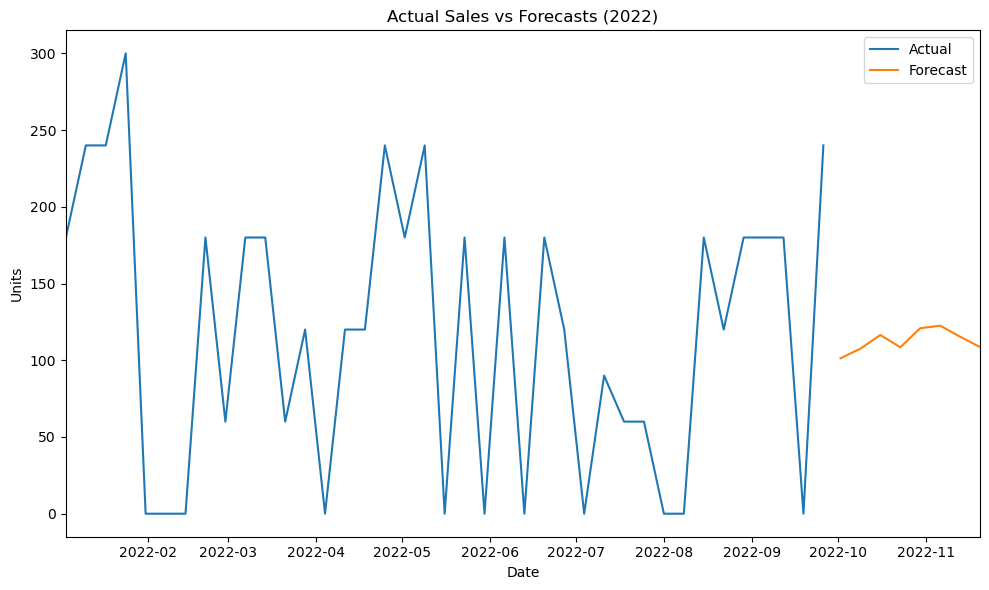

In [169]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120009816

In [170]:
specific_id = 120009816

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [171]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ARIMA(train_data['Units'], order=(0, 0, 0), seasonal_order=(1, 0, 0, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 43.26%
Train SMAPE: 97.95%
Forecasted Values:
2022-10-02    604.144273
2022-10-09    604.144273
2022-10-16    678.884143
2022-10-23    660.199176
2022-10-30    632.171724
2022-11-06    613.486757
2022-11-13    622.829241
2022-11-20    622.829241
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

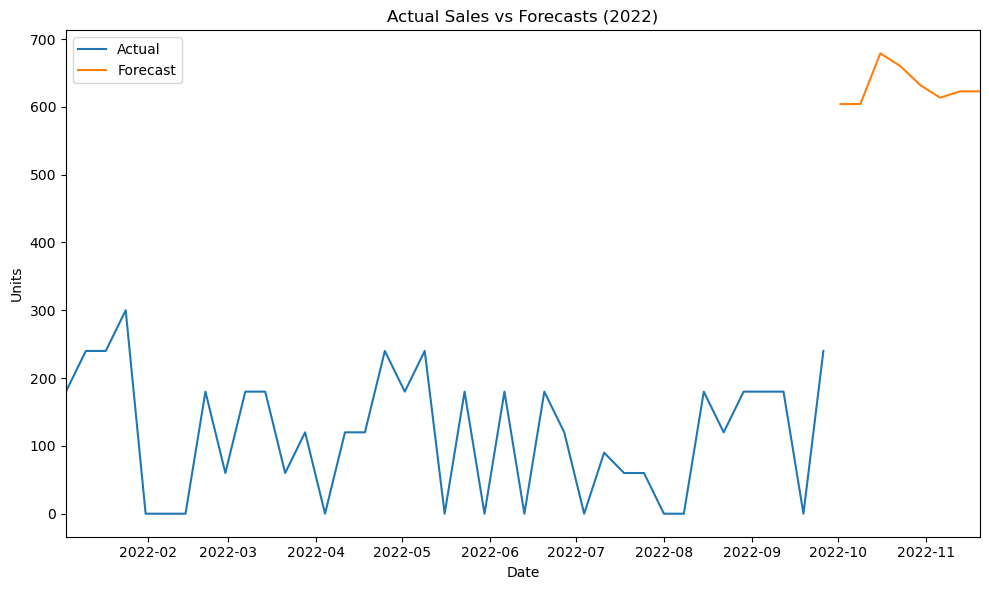

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120011782

In [173]:
specific_id = 120011782

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [174]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(2, 0, 0), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index
smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 18.58%
Train SMAPE: 20.05%
Forecasted Values:
2022-10-02    3197.660430
2022-10-09    3063.224228
2022-10-16    2914.921823
2022-10-23    2824.000686
2022-10-30    2747.438460
2022-11-06    2693.699730
2022-11-13    2651.952996
2022-11-20    2621.335654
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

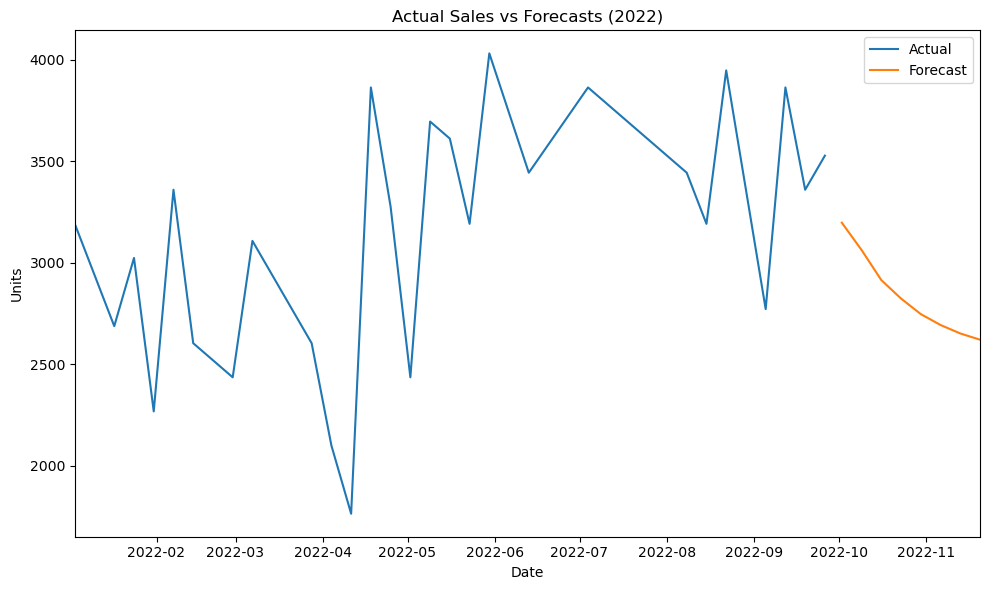

In [175]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120014486

In [176]:
specific_id = 120014486

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [177]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertibl

Test SMAPE: 57.63%
Train SMAPE: 74.63%
Forecasted Values:
2022-10-02    1317.530488
2022-10-09    1220.363491
2022-10-16    2629.927107
2022-10-23    2518.408660
2022-10-30    2434.704137
2022-11-06    2277.618351
2022-11-13    2029.071228
2022-11-20    2533.291799
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


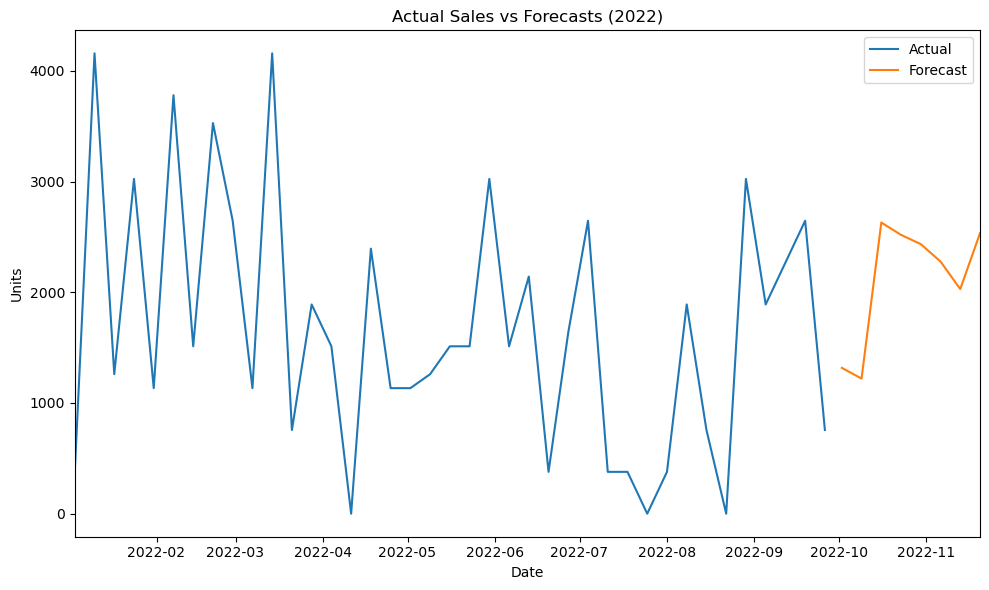

In [178]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()
plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120014488

In [179]:
specific_id = 120014488

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [180]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ARIMA(train_data['Units'], order=(2, 0, 1), seasonal_order=(0, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test SMAPE: 33.12%
Train SMAPE: 72.23%
Forecasted Values:
2022-10-02    2529.307067
2022-10-09    2394.857718
2022-10-16    2265.086290
2022-10-23    2234.831831
2022-10-30    2184.955799
2022-11-06    2153.377907
2022-11-13    2259.753470
2022-11-20    2237.111294
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

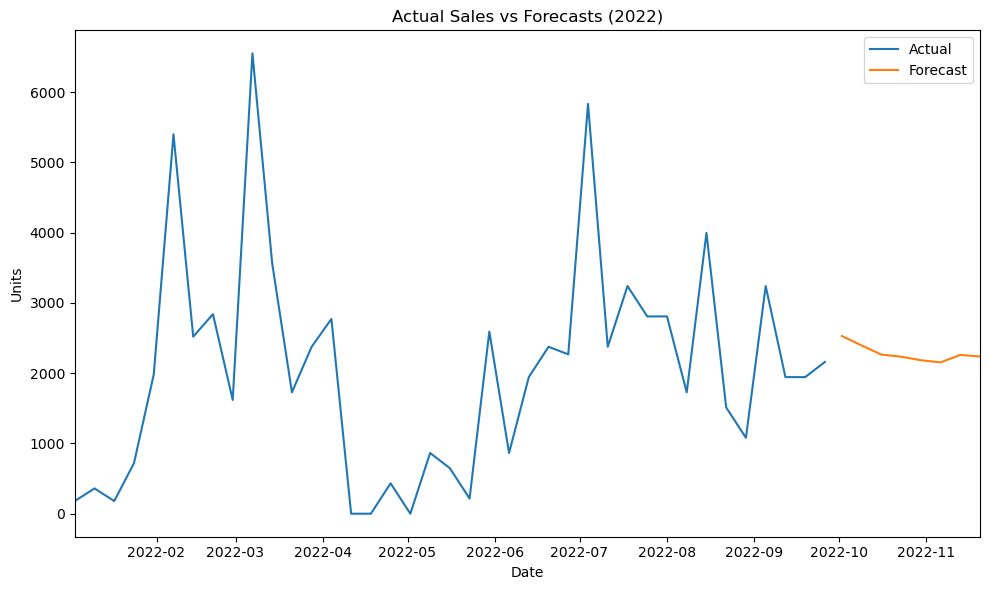

In [181]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120015996

In [182]:
specific_id = 120015996

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [183]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(0, 0, 1), seasonal_order=(0, 1, 0, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100
print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 75.55%
Train SMAPE: 134.10%
Forecasted Values:
2022-10-02    1661.145627
2022-10-09     976.000000
2022-10-16     676.000000
2022-10-23      48.000000
2022-10-30     280.000000
2022-11-06    1684.000000
2022-11-13    1580.000000
2022-11-20    1676.000000
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

### Actual Sales vs Forecast 2022

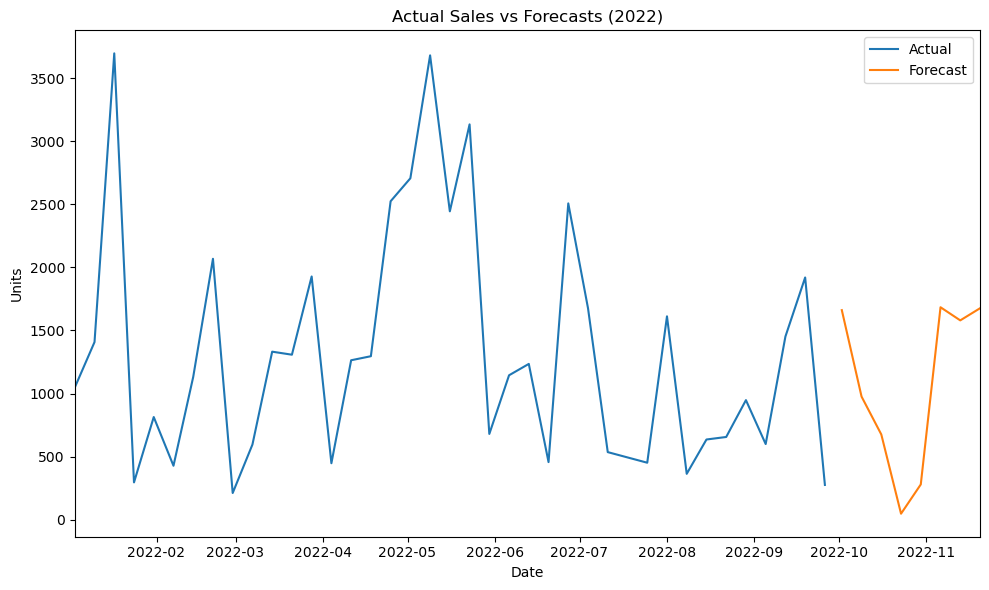

In [184]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120015842

In [185]:
specific_id = 120015842

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [186]:
train_data = filtered_data.iloc[:-8] 
test_data = filtered_data.iloc[-8:]   

model = ARIMA(train_data['Units'], order=(2, 1, 2), seasonal_order=(0, 0, 1, 52))
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variance

Test SMAPE: 46.52%
Train SMAPE: 73.91%
Forecasted Values:
2022-10-02    209.171892
2022-10-09    199.642784
2022-10-16    185.613076
2022-10-23    224.255883
2022-10-30    217.850258
2022-11-06    236.286621
2022-11-13    230.155252
2022-11-20    254.900580
Freq: W-SUN, Name: predicted_mean, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecasts 2022

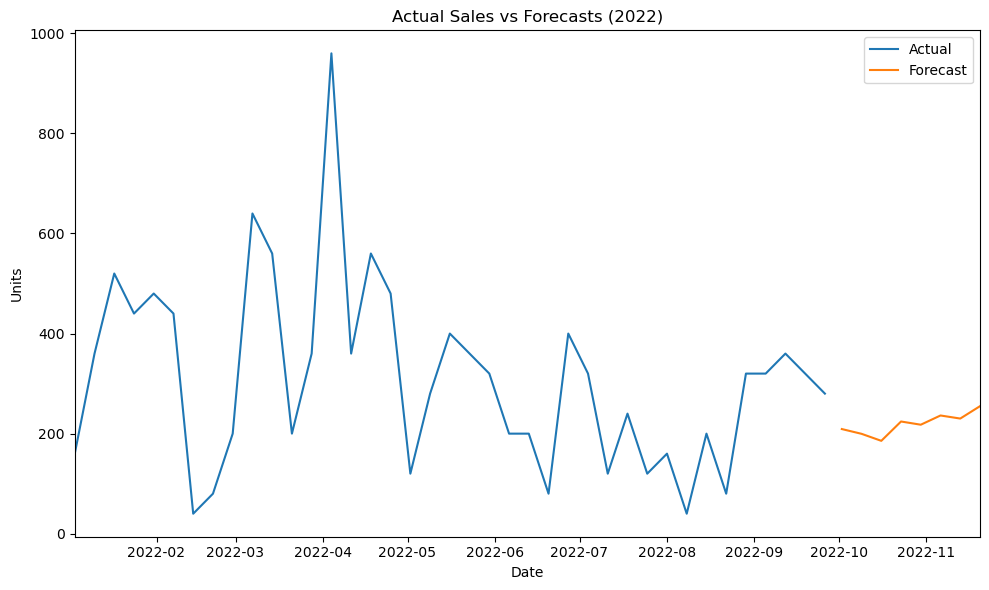

In [187]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

# HOLT WINTERS

## ID = 120010970

In [188]:
specific_id = 120010970

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [189]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)  #next 8 weeks in the test data

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')  #index for the forecasted values

forecast.index = pred_index

#sMAPE for testing
smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

#sMAPE for training
smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 43.68%
Train SMAPE: 57.41%
Forecasted Values:
2022-10-02    1027.915462
2022-10-09    1371.080479
2022-10-16    1437.444111
2022-10-23    1148.135082
2022-10-30    1138.988027
2022-11-06    1346.559867
2022-11-13     923.741043
2022-11-20    1128.031199
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecasts 2022

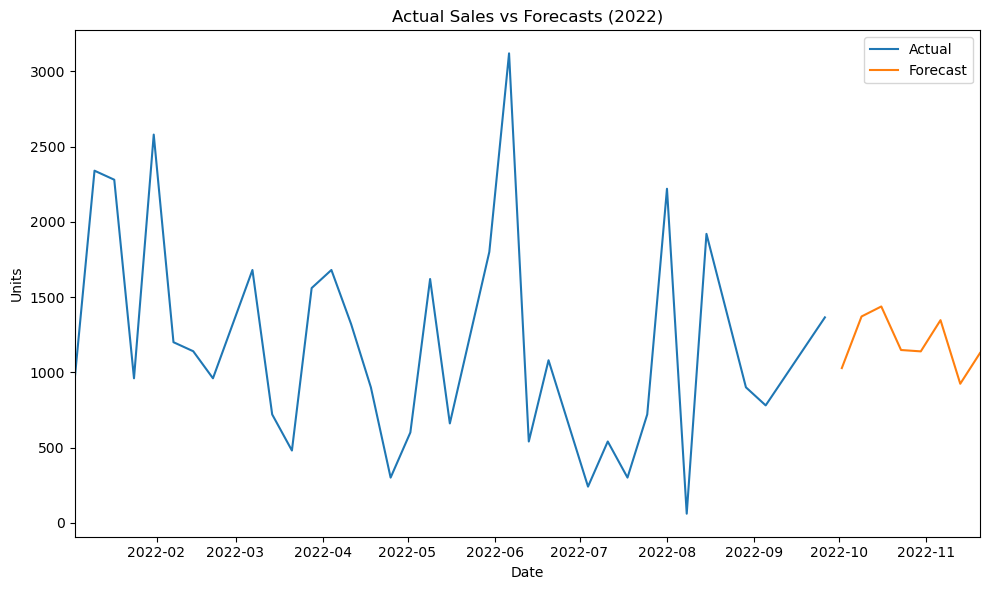

In [190]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120012606

In [191]:
specific_id = 120012606

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [192]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 93.13%
Train SMAPE: 88.51%
Forecasted Values:
2022-10-02     572.845848
2022-10-09    1038.776470
2022-10-16     300.850412
2022-10-23    1358.843691
2022-10-30    1867.889676
2022-11-06    2417.804353
2022-11-13     259.624173
2022-11-20    2767.671124
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

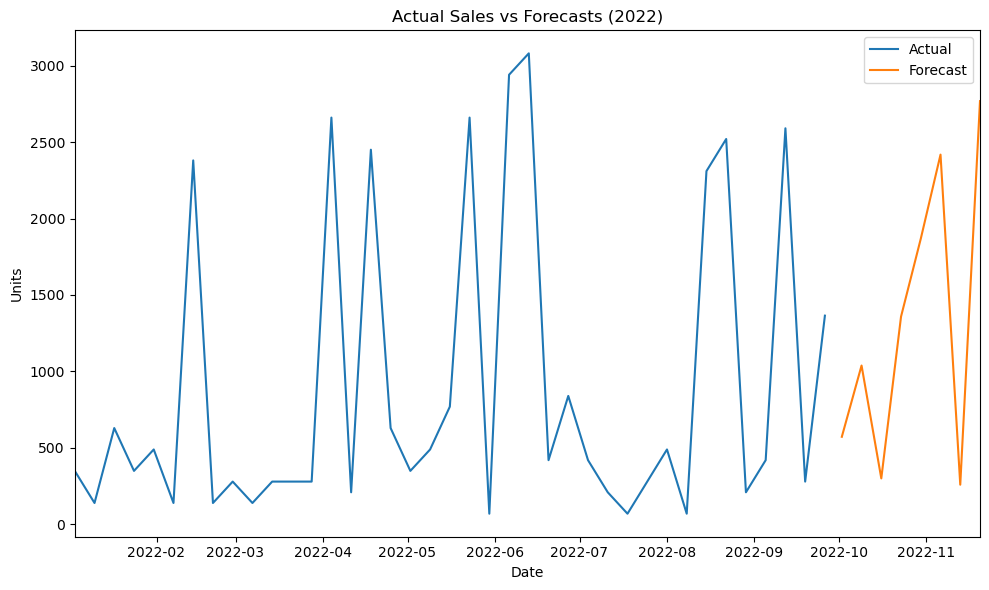

In [193]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120011556

In [194]:
specific_id = 120011556

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [195]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()


forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 76.00%
Train SMAPE: 40.63%
Forecasted Values:
2022-10-02    265.065722
2022-10-09    196.382522
2022-10-16    191.894410
2022-10-23    183.224804
2022-10-30    149.879177
2022-11-06    316.229692
2022-11-13    547.115927
2022-11-20    180.735068
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

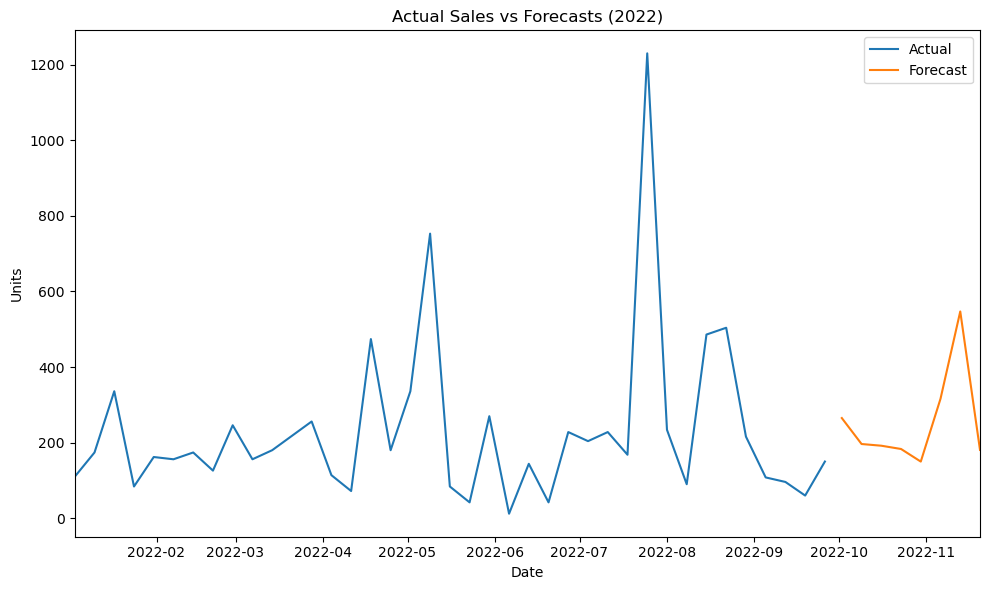

In [196]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120010566

In [197]:
specific_id = 120010566

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [198]:
train_data = filtered_data.iloc[:-8] 
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 192.97%
Train SMAPE: 104.49%
Forecasted Values:
2022-10-02    8216.077242
2022-10-09    7706.511001
2022-10-16    6979.583413
2022-10-23    7878.744595
2022-10-30    7321.160078
2022-11-06    7362.744673
2022-11-13    6714.064132
2022-11-20    7176.618766
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

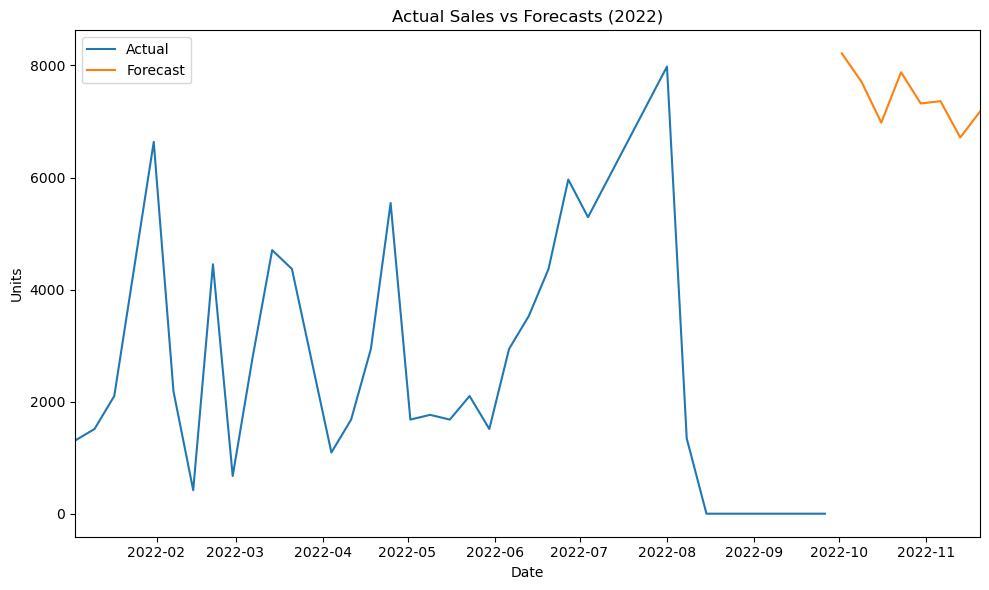

In [199]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120010342

In [200]:
specific_id = 120010342

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [201]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 45.74%
Train SMAPE: 68.55%
Forecasted Values:
2022-10-02     598.878577
2022-10-09     369.155740
2022-10-16     545.315209
2022-10-23    1237.737260
2022-10-30     378.547311
2022-11-06     496.966020
2022-11-13     549.922315
2022-11-20     313.246350
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

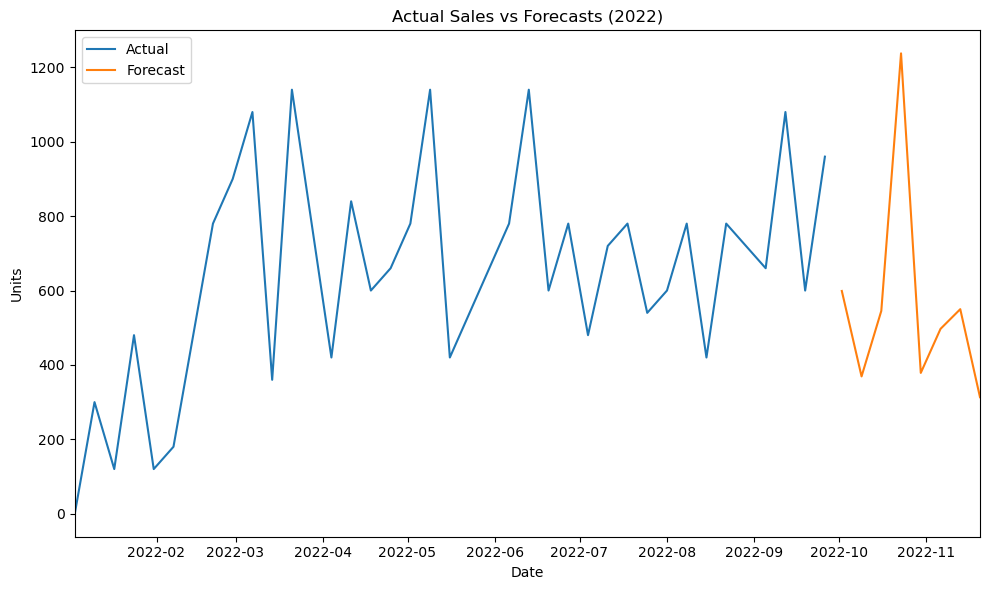

In [202]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120009814

In [203]:
specific_id = 120009814

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)


In [204]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 90.44%
Train SMAPE: 80.15%
Forecasted Values:
2022-10-02    560.090300
2022-10-09    606.709233
2022-10-16    663.801652
2022-10-23    506.134533
2022-10-30    349.348435
2022-11-06    398.464409
2022-11-13    298.123665
2022-11-20     92.901011
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

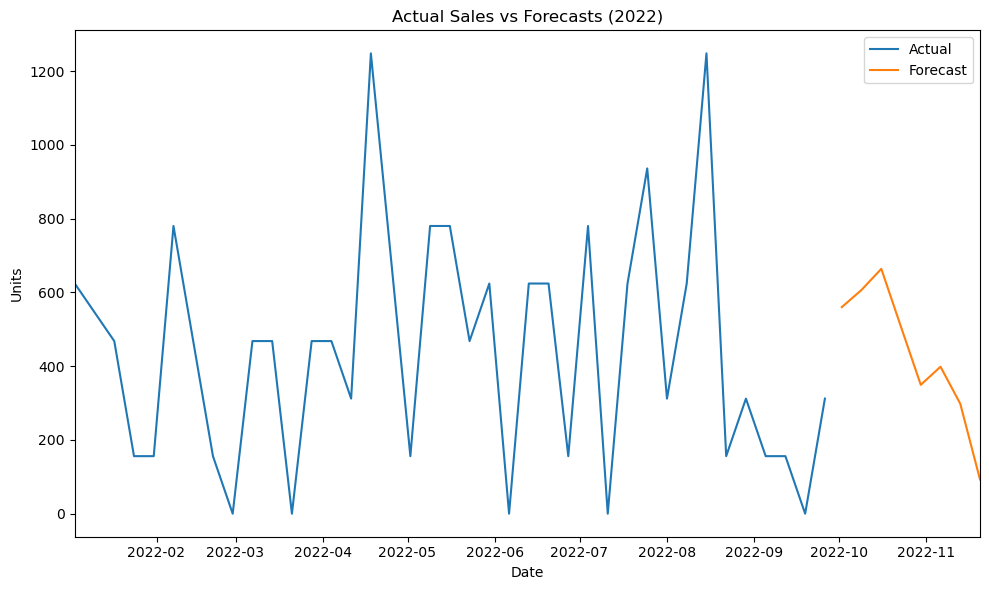

In [205]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120012154

In [206]:
specific_id = 120012154

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)


In [207]:
train_data = filtered_data.iloc[:-8] 
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 173.80%
Train SMAPE: 35.65%
Forecasted Values:
2022-10-02    2884.624519
2022-10-09    2156.132723
2022-10-16    1929.303493
2022-10-23    1492.732522
2022-10-30    1211.102282
2022-11-06    1142.172591
2022-11-13    1202.349575
2022-11-20    1060.659817
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

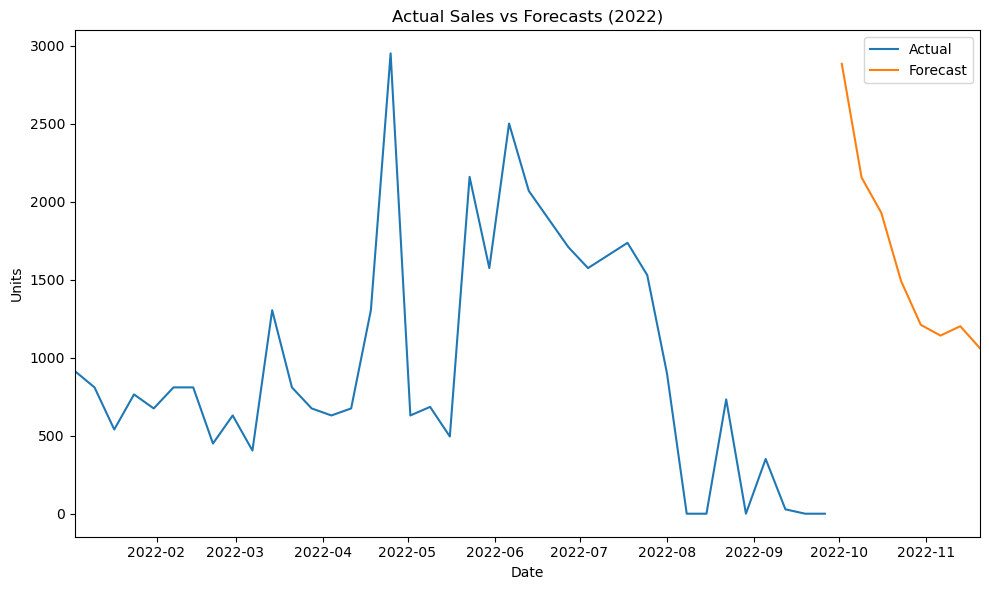

In [208]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120004096

In [209]:
specific_id = 120004096

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [210]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 79.61%
Train SMAPE: 82.05%
Forecasted Values:
2022-10-02     46.680734
2022-10-09    112.059015
2022-10-16    153.001874
2022-10-23     93.164680
2022-10-30    204.537758
2022-11-06    175.916364
2022-11-13    182.344365
2022-11-20     93.907269
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

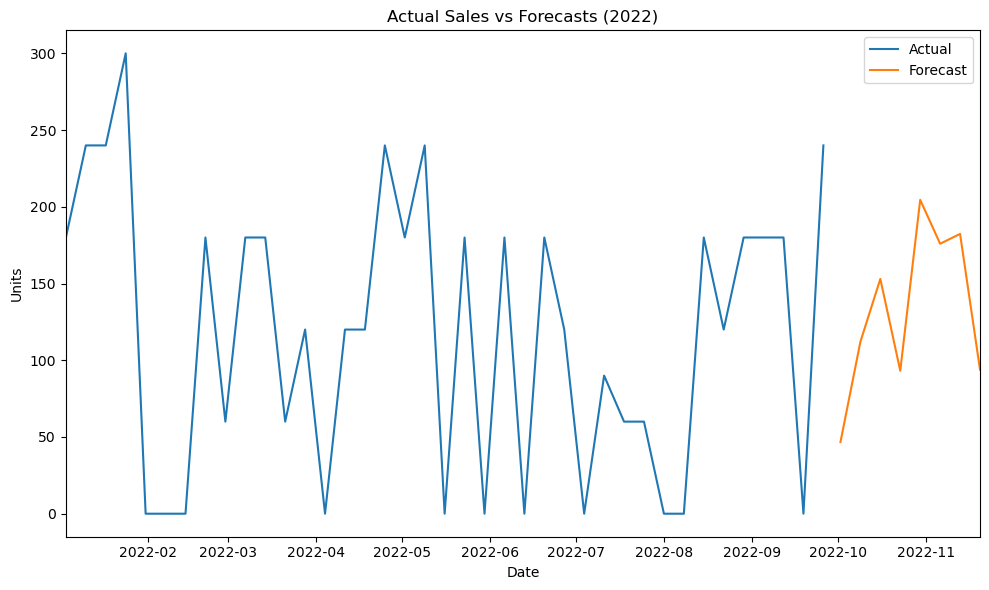

In [211]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120009816

In [212]:
specific_id = 120009816

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [213]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index


smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 60.18%
Train SMAPE: 96.69%
Forecasted Values:
2022-10-02    526.380152
2022-10-09    426.084456
2022-10-16    745.011008
2022-10-23    725.311455
2022-10-30    564.916093
2022-11-06    457.478446
2022-11-13    872.616041
2022-11-20    592.422706
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

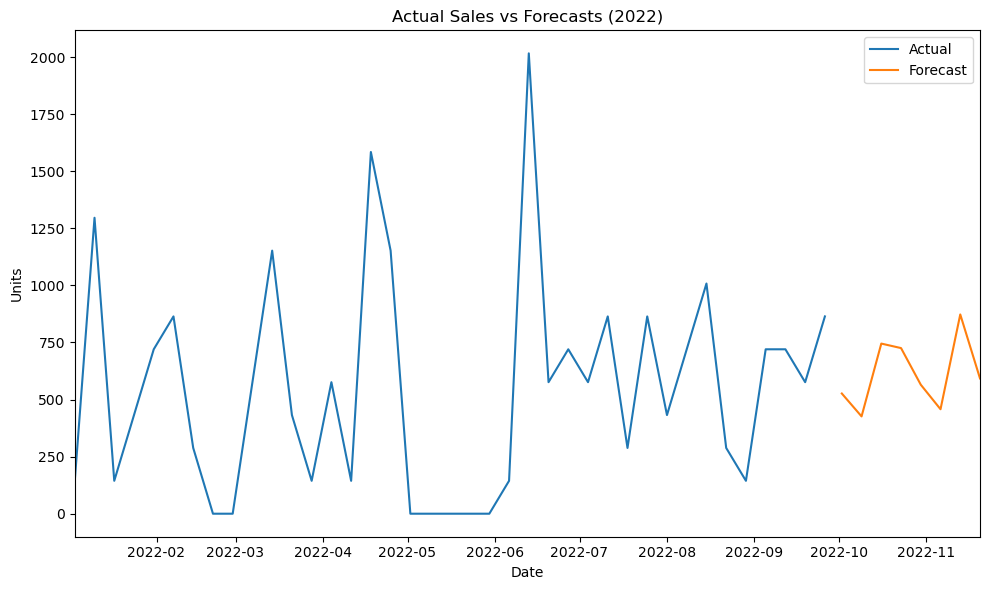

In [214]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120011782

In [215]:
specific_id = 120011782

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [216]:
train_data = filtered_data.iloc[:-8] 
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 10.96%
Train SMAPE: 46.86%
Forecasted Values:
2022-10-02    3944.701325
2022-10-09    3834.478222
2022-10-16    4023.740356
2022-10-23    3330.881911
2022-10-30    3311.451318
2022-11-06    3622.586422
2022-11-13    3974.530710
2022-11-20    3984.533419
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

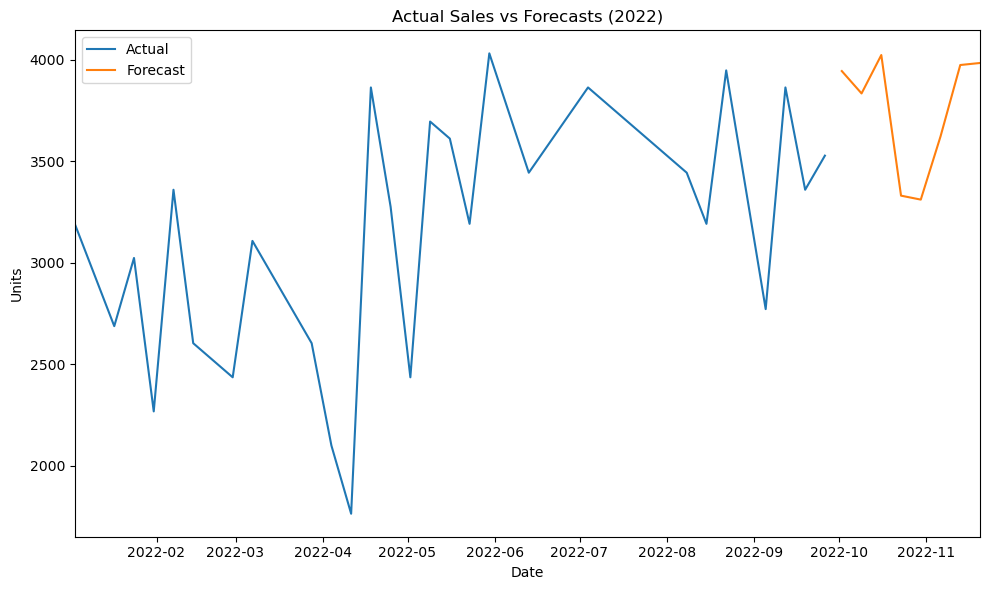

In [217]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120014486

In [218]:
specific_id = 120014486

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)


In [219]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 74.20%
Train SMAPE: 52.47%
Forecasted Values:
2022-10-02    1361.026948
2022-10-09     715.853936
2022-10-16    2084.125093
2022-10-23    1552.866048
2022-10-30    1026.478059
2022-11-06    1134.668249
2022-11-13     780.428548
2022-11-20    1352.556209
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

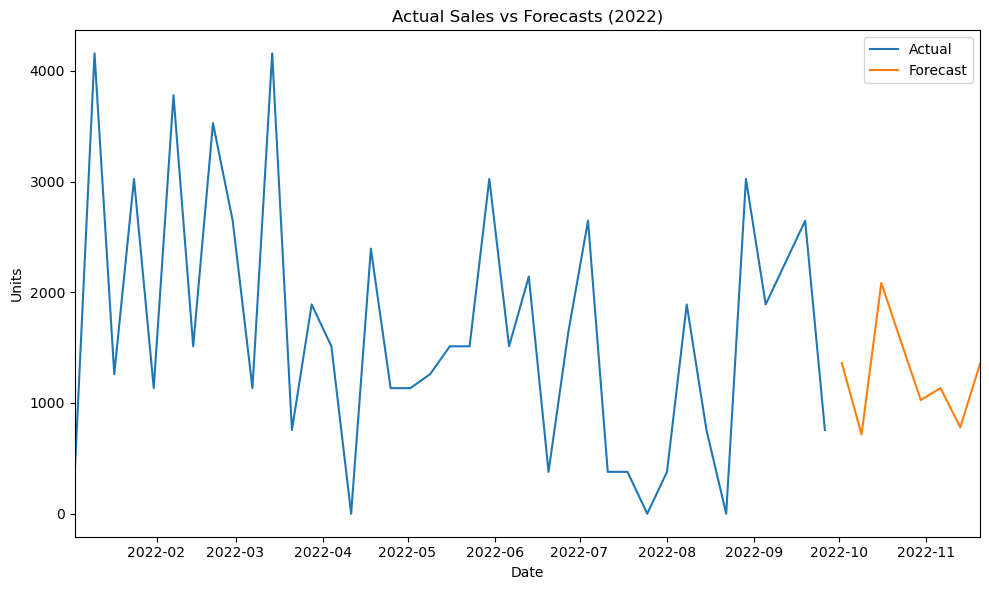

In [220]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120014488

In [221]:
specific_id = 120014488

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)


In [222]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 63.88%
Train SMAPE: 102.53%
Forecasted Values:
2022-10-02    3307.853645
2022-10-09    2674.579395
2022-10-16    4201.461317
2022-10-23    4821.578259
2022-10-30    3042.486650
2022-11-06    3413.603247
2022-11-13    3886.171054
2022-11-20    4009.823637
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

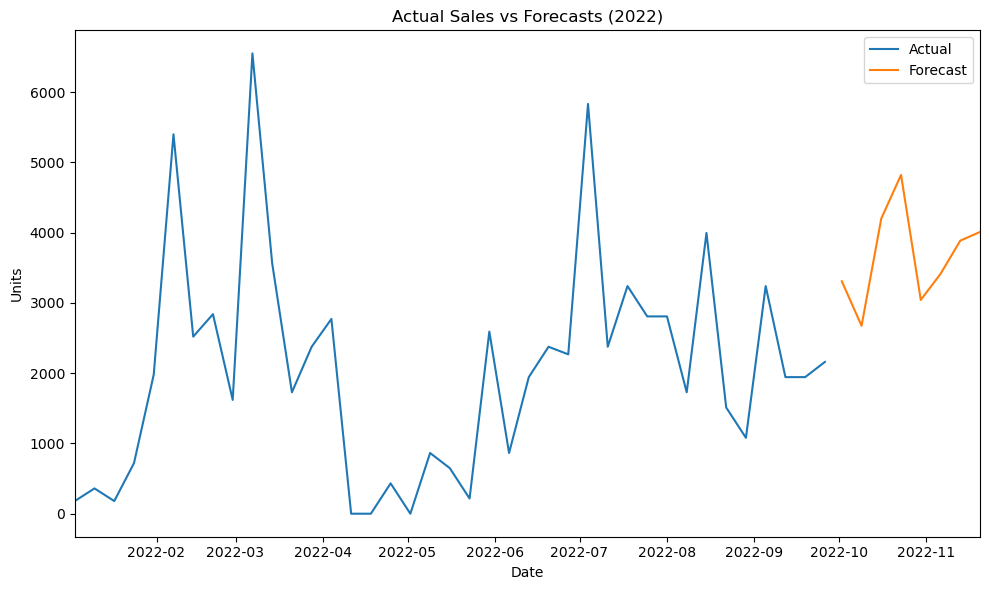

In [223]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120015996

In [224]:
specific_id = 120015996

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [225]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]   

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=52)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 71.30%
Train SMAPE: 136.33%
Forecasted Values:
2022-10-02    1334.883030
2022-10-09    1356.940364
2022-10-16    1460.457140
2022-10-23    2022.159716
2022-10-30     630.376230
2022-11-06     965.042850
2022-11-13    1395.057760
2022-11-20    2386.000833
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

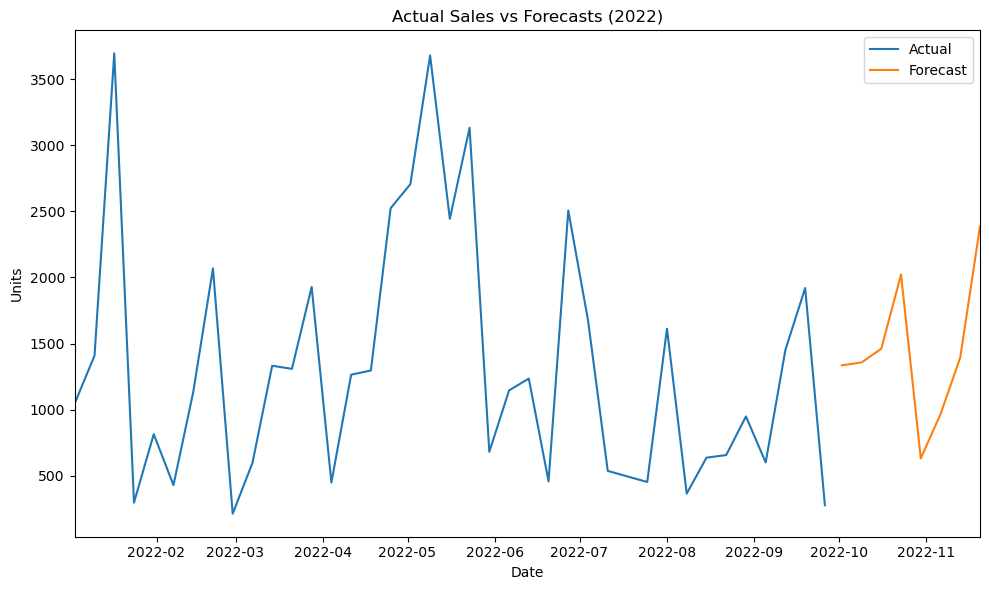

In [226]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

## ID = 120015842

In [227]:
specific_id = 120015842

filtered_data = df[df['ID_material'] == specific_id]

filtered_data.set_index('year_week', inplace=True)

In [228]:
train_data = filtered_data.iloc[:-8]  
test_data = filtered_data.iloc[-8:]  

model = ExponentialSmoothing(train_data['Units'], trend="add", seasonal="add", seasonal_periods=46)
model_fit = model.fit()

forecast = model_fit.forecast(steps=8)

pred_index = pd.date_range(start=filtered_data.index[-2] + pd.DateOffset(7), periods=8, freq='W')

forecast.index = pred_index

smape = (2 * np.abs(test_data['Units'].values - forecast.values) / (np.abs(test_data['Units'].values) + np.abs(forecast.values))).mean()
test_smape_percentage = smape * 100

smape2 = (2 * np.abs(train_data['Units'].values[:8] - forecast.values) / (np.abs(train_data['Units'].values[:8]) + np.abs(forecast.values))).mean()
train_smape_percentage = smape2 * 100

print("Test SMAPE: {:.2f}%".format(test_smape_percentage))
print("Train SMAPE: {:.2f}%".format(train_smape_percentage))

print("Forecasted Values:")
print(forecast)

Test SMAPE: 74.01%
Train SMAPE: 51.35%
Forecasted Values:
2022-10-02    483.076316
2022-10-09    640.172259
2022-10-16    646.700206
2022-10-23    406.013048
2022-10-30    437.936157
2022-11-06    524.680648
2022-11-13    481.072588
2022-11-20    377.542229
Freq: W-SUN, dtype: float64


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Actual Sales vs Forecast 2022

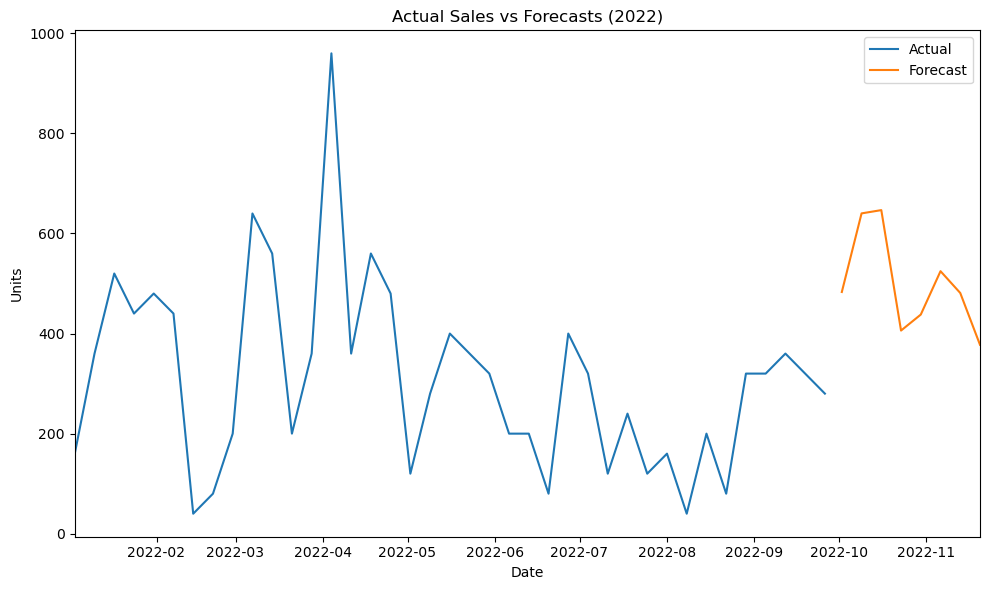

In [229]:
filtered_data_2022 = filtered_data.loc['2022']

plt.figure(figsize=(10, 6))
plt.plot(filtered_data_2022.index, filtered_data_2022['Units'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Actual Sales vs Forecasts (2022)')
plt.legend()

plt.xlim([filtered_data_2022.index[0], forecast.index[-1]])

plt.tight_layout()
plt.show()

# XGBOOST MODELS

## XGBoost

### Better result - IDs =  120010970,120009814

In [230]:
results = {}

for specific_id in unique_ids:

    dates = sorted(df[df['ID_material'] == specific_id]['year_week'].unique())  #list of dates based on the 'year_week' column
    filtered_data = df[(df['ID_material'] == specific_id) & (df['year_week'].isin(dates))].sort_values('year_week')     #filter the data by the specific ID and dates

    #split data
    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    #prepare the data for XGBoost
    xgb_train_data = train_data.copy()
    xgb_train_data['lag1'] = train_data['Units'].shift(1)
    xgb_train_data['lag2'] = train_data['Units'].shift(2)
    xgb_train_data = xgb_train_data.dropna()

    #fit the model
    xgb_model = xgb.XGBRegressor(n_estimators=1000)
    xgb_model.fit(xgb_train_data[['lag1', 'lag2']], xgb_train_data['Units'])

    #prepare the test data for XGBoost
    test_data['lag1'] = test_data['Units'].shift(1)
    test_data['lag2'] = test_data['Units'].shift(2)

    xgb_forecast = []       #predict the values

    for i in range(8):  #forecast 8 steps ahead (8 weeks =| 2 months)
        last_observation = xgb_train_data.iloc[-1][['lag1', 'lag2']].values.reshape(1, -1)
        prediction = xgb_model.predict(last_observation)
        xgb_forecast.append(prediction[0])
        new_observation = pd.DataFrame({
            'lag1': [xgb_train_data.iloc[-1]['lag2']],
            'lag2': [prediction[0]]
        })
        xgb_train_data = pd.concat([xgb_train_data, new_observation], ignore_index=True)

    #Calculate SMAPE
    xgb_smape = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    #store the forecasted values and SMAPE in the results dictionary
    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape
    }

#forecasted values & SMAPE for each ID
for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Forecasted Values:")
    print(result['forecast'])
    print("XGBoost SMAPE: {:.2f}%".format(result['smape']))
    print("\n")


ID_material:  120004096
XGBoost Forecasted Values:
[159.9968, 135.91846, -0.0003697511, 100.9027, 63.296547, 63.92146, 159.9968, 135.91846]
XGBoost SMAPE: 116.34%


ID_material:  120014488
XGBoost Forecasted Values:
[2808.002, 4130.013, 1082.0228, 3256.17, 2153.366, 1184.9834, 4638.568, 1591.4489]
XGBoost SMAPE: 48.18%


ID_material:  120014486
XGBoost Forecasted Values:
[189.0011, 377.9969, 377.9969, 377.9969, 377.9969, 377.9969, 377.9969, 377.9969]
XGBoost SMAPE: 134.84%


ID_material:  120009816
XGBoost Forecasted Values:
[960.001, 1152.0018, 647.9973, 982.44934, 519.78094, 108.009636, 858.5764, 279.98727]
XGBoost SMAPE: 73.66%


ID_material:  120015996
XGBoost Forecasted Values:
[1611.9965, 1390.4698, 1843.161, 1993.9629, 1554.0798, 1568.3651, 1193.5316, 1423.8453]
XGBoost SMAPE: 80.61%


ID_material:  120009814
XGBoost Forecasted Values:
[311.99997, 331.50012, 312.00415, 312.00415, 312.00415, 312.00415, 312.00415, 312.00415]
XGBoost SMAPE: 72.84%


ID_material:  120010342
XGBoost 

## XGBoost demand forecasting model with rolling features 

### Better result - ID = 120010342

In [231]:
results = {}

for specific_id in unique_ids:

    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]

    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    xgb_train_data = train_data.copy()
    xgb_train_data['lag1'] = train_data['Units'].shift(1)
    xgb_train_data['lag2'] = train_data['Units'].shift(2)
    xgb_train_data['rolling_mean'] = train_data['Units'].rolling(window=2).mean()
    xgb_train_data['rolling_std'] = train_data['Units'].rolling(window=2).std()

    xgb_train_data = xgb_train_data.dropna()

    xgb_model = xgb.XGBRegressor(n_estimators=1000)
    xgb_model.fit(xgb_train_data[['lag1', 'lag2', 'rolling_mean', 'rolling_std']], xgb_train_data['Units'])
    test_data['lag1'] = test_data['Units'].shift(1)
    test_data['lag2'] = test_data['Units'].shift(2)
    test_data['rolling_mean'] = test_data['Units'].rolling(window=2).mean()
    test_data['rolling_std'] = test_data['Units'].rolling(window=2).std()

    xgb_forecast = []

    for i in range(8):  
        last_observation = xgb_train_data.iloc[-1][['lag1', 'lag2', 'rolling_mean', 'rolling_std']].values.reshape(1, -1)
        prediction = xgb_model.predict(last_observation)
        xgb_forecast.append(prediction[0])

        new_observation = pd.DataFrame({
            'lag1': [xgb_train_data.iloc[-1]['lag2']],
            'lag2': [prediction[0]],
            'rolling_mean': [xgb_train_data.iloc[-2:]['lag2'].mean()],
            'rolling_std': [xgb_train_data.iloc[-2:]['lag2'].std()]
        })
        xgb_train_data = pd.concat([xgb_train_data, new_observation], ignore_index=True)

    xgb_smape = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape
    }

for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Forecasted Values:")
    print(result['forecast'])
    print("XGBoost SMAPE: {:.2f}%".format(result['smape']))
    print("\n")


ID_material:  120004096
XGBoost Forecasted Values:
[0.0015638734, 107.81195, 59.99991, -0.0010938761, 119.92839, 59.99991, -0.0010938761, 119.99986]
XGBoost SMAPE: 115.44%


ID_material:  120014488
XGBoost Forecasted Values:
[2808.0, 2599.501, 3225.6238, 2796.2136, 2670.921, 3152.5752, 2754.6958, 2801.3132]
XGBoost SMAPE: 47.24%


ID_material:  120014486
XGBoost Forecasted Values:
[377.99252, 184.85161, 182.20398, 368.6527, 373.2252, 22.414976, 182.20398, 378.00403]
XGBoost SMAPE: 147.79%


ID_material:  120009816
XGBoost Forecasted Values:
[431.9991, 869.1025, 294.13373, 431.9991, 869.1025, 294.1314, 431.9991, 869.1025]
XGBoost SMAPE: 37.35%


ID_material:  120015996
XGBoost Forecasted Values:
[1611.9998, 525.39215, 548.90027, 1590.1824, 663.8742, 535.5374, 1572.8711, 662.9839]
XGBoost SMAPE: 52.30%


ID_material:  120009814
XGBoost Forecasted Values:
[311.99902, 0.0010098988, 623.9912, 312.0008, 0.0010098988, 623.9912, 312.0008, 0.0010098988]
XGBoost SMAPE: 138.33%


ID_material:  12

## XGBoost Direct Multi step demand forecasting model 

### Best Results = 120015842,120012154

In [233]:
results = {}

for specific_id in unique_ids:

    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]
    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    xgb_train_data = train_data.copy()
    xgb_train_data['lag1'] = train_data['Units'].shift(1)
    xgb_train_data['lag2'] = train_data['Units'].shift(2)
    xgb_train_data = xgb_train_data.dropna()

    #direct multi-step forecasting
    xgb_forecast = []
    for i in range(8):
        #prepare the target variable for the i-th step ahead
        y_train_direct = xgb_train_data['Units'].shift(-i).dropna()
        x_train_direct = xgb_train_data.loc[y_train_direct.index][['lag1', 'lag2']]
       
        #fit
        xgb_model_direct = xgb.XGBRegressor(n_estimators=1000)
        xgb_model_direct.fit(x_train_direct, y_train_direct)
        
        #predict the i-th step ahead
        last_observation_direct = xgb_train_data.iloc[-(i+1)][['lag1', 'lag2']].values.reshape(1, -1)
        prediction_direct = xgb_model_direct.predict(last_observation_direct)
        xgb_forecast.append(prediction_direct[0])

    xgb_smape_direct = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape_direct
    }

for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Direct Multi-step Forecasted Values:")
    print(result['forecast'])
    print("XGBoost Direct Multi-step SMAPE: {:.2f}%".format(result['smape']))
    print("\n")


ID_material:  120004096
XGBoost Direct Multi-step Forecasted Values:
[159.9968, 149.99886, 0.0037031162, 96.00032, 127.99933, 115.294106, 115.71381, 149.99985]
XGBoost Direct Multi-step SMAPE: 100.35%


ID_material:  120014488
XGBoost Direct Multi-step Forecasted Values:
[2808.002, 2808.002, 2808.0, 2808.0002, 2807.9949, 2807.9985, 2807.9988, 2807.9998]
XGBoost Direct Multi-step SMAPE: 43.07%


ID_material:  120014486
XGBoost Direct Multi-step Forecasted Values:
[189.0011, 566.9988, 378.00095, 377.99805, 378.00278, 378.00183, 378.0057, 1301.9989]
XGBoost Direct Multi-step SMAPE: 128.38%


ID_material:  120009816
XGBoost Direct Multi-step Forecasted Values:
[960.001, 383.99603, 647.9873, 432.0033, 460.79886, 431.9999, 432.00064, 239.99991]
XGBoost Direct Multi-step SMAPE: 66.33%


ID_material:  120015996
XGBoost Direct Multi-step Forecasted Values:
[1611.9965, 1611.9974, 1612.0005, 1611.9996, 1611.9998, 1611.9988, 1612.0026, 1611.9961]
XGBoost Direct Multi-step SMAPE: 76.28%


ID_materi

## XGBoost Direct Multi-step Demand Forecasting Model with Lagged Features

### ID = 120012154 - same value as Direct 

In [234]:
results = {}

for specific_id in unique_ids:
    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]

    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    xgb_train_data = train_data.copy()
    for i in range(1, 6):  # Adding more lagged features
        xgb_train_data[f'lag{i}'] = train_data['Units'].shift(i)
    xgb_train_data = xgb_train_data.dropna()

    # Direct multi-step orecasting
    xgb_forecast = []
    for i in range(8):
        #prepare the target variable for the i-th step ahead
        y_train_direct = xgb_train_data['Units'].shift(-i).dropna()
        x_train_direct = xgb_train_data.loc[y_train_direct.index][[f'lag{j}' for j in range(1, 6)]]  # Use more lagged features

        #fit
        xgb_model_direct = xgb.XGBRegressor(n_estimators=1000)
        xgb_model_direct.fit(x_train_direct, y_train_direct)
        
        #predict the i-th step ahead
        last_observation_direct = xgb_train_data.iloc[-(i+1)][[f'lag{j}' for j in range(1, 6)]].values.reshape(1, -1)
        prediction_direct = xgb_model_direct.predict(last_observation_direct)
        xgb_forecast.append(prediction_direct[0])

    xgb_smape_direct = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape_direct
    }

for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Direct Multi-step Forecasted Values:")
    print(result['forecast'])
    print("XGBoost Direct Multi-step SMAPE: {:.2f}%".format(result['smape']))
    print("\n")

ID_material:  120004096
XGBoost Direct Multi-step Forecasted Values:
[0.0004256978, 0.0030629686, 0.0022124352, 60.00112, 0.0068365065, 60.00058, 60.000443, -9.394975e-05]
XGBoost Direct Multi-step SMAPE: 175.00%


ID_material:  120014488
XGBoost Direct Multi-step Forecasted Values:
[2808.0005, 2808.0002, 2808.0005, 2808.0002, 2807.9995, 2808.0002, 2807.9998, 2808.0002]
XGBoost Direct Multi-step SMAPE: 43.07%


ID_material:  120014486
XGBoost Direct Multi-step Forecasted Values:
[378.00085, 377.99988, 377.99905, 378.0004, 377.99844, 377.99976, 377.9972, 378.0038]
XGBoost Direct Multi-step SMAPE: 131.05%


ID_material:  120009816
XGBoost Direct Multi-step Forecasted Values:
[431.99887, 431.99893, 432.00058, 432.0, 432.00006, 431.9981, 431.99902, 432.00613]
XGBoost Direct Multi-step SMAPE: 58.15%


ID_material:  120015996
XGBoost Direct Multi-step Forecasted Values:
[1612.0001, 1611.9995, 1612.0006, 1612.0, 1611.9994, 1612.0, 1612.0006, 1611.9998]
XGBoost Direct Multi-step SMAPE: 76.28%


## Best results - ID = 120012606,120011556,120010566,120004096,120011782,120014486

In [235]:
results = {}

# Define the hyperparameter grid for XGBoost
param_grid = {
    "learning_rate": np.linspace(0.01, 0.2, 5),
    "max_depth": range(3, 10),
    "n_estimators": range(50, 200, 50),
    "subsample": np.linspace(0.5, 1, 3),
    "colsample_bytree": np.linspace(0.5, 1, 3),
}

for specific_id in unique_ids:
    # Filter the data by the specific ID
    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    # Generate the list of dates based on the 'year_week' column
    dates = sorted(filtered_data['year_week'].unique())

    # Filter the data by dates
    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]

    # Split the data into train and test sets
    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    # Prepare the data for XGBoost
    xgb_train_data = train_data.copy()
    for i in range(1, 6):  # Adding more lagged features
        xgb_train_data[f'lag{i}'] = train_data['Units'].shift(i)

    xgb_train_data = xgb_train_data.dropna()

    # Direct multi-step forecasting
    xgb_forecast = []
    for i in range(8):
        # Prepare the target variable for the i-th step ahead
        y_train_direct = xgb_train_data['Units'].shift(-i).dropna()
        x_train_direct = xgb_train_data.loc[y_train_direct.index][[f'lag{j}' for j in range(1, 6)]]  # Use more lagged features

        # Initialize the model
        xgb_model_direct = xgb.XGBRegressor()

        # Set up and fit the RandomizedSearchCV
        rs_cv = RandomizedSearchCV(xgb_model_direct, param_grid, n_iter=5, cv=3, random_state=42)
        rs_cv.fit(x_train_direct, y_train_direct)

        # Predict the i-th step ahead
        last_observation_direct = xgb_train_data.iloc[-(i+1)][[f'lag{j}' for j in range(1, 6)]].values.reshape(1, -1)
        prediction_direct = rs_cv.best_estimator_.predict(last_observation_direct)
        xgb_forecast.append(prediction_direct[0])

    # Calculate SMAPE
    xgb_smape_direct = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    # Store the forecasted values and SMAPE in the results dictionary
    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape_direct
    }

# Print the forecasted values and SMAPE for each ID
for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Direct Multi-step Forecasted Values:")
    print(result['forecast'])
    print("XGBoost Direct Multi-step SMAPE: {:.2f}%".format(result['smape']))
    print("\n")


ID_material:  120004096
XGBoost Direct Multi-step Forecasted Values:
[91.00462, 60.04472, 81.854, 116.579926, 140.16548, 100.569756, 100.61704, 120.863655]
XGBoost Direct Multi-step SMAPE: 91.01%


ID_material:  120014488
XGBoost Direct Multi-step Forecasted Values:
[2756.1958, 2564.33, 2637.413, 2671.6921, 2482.3171, 2490.569, 2612.0898, 3052.183]
XGBoost Direct Multi-step SMAPE: 42.91%


ID_material:  120014486
XGBoost Direct Multi-step Forecasted Values:
[394.5245, 517.3696, 503.67902, 752.7111, 865.6215, 788.24963, 550.303, 521.3008]
XGBoost Direct Multi-step SMAPE: 103.47%


ID_material:  120009816
XGBoost Direct Multi-step Forecasted Values:
[480.0173, 470.91278, 470.32208, 370.98135, 410.3434, 347.76978, 357.3607, 385.85022]
XGBoost Direct Multi-step SMAPE: 62.09%


ID_material:  120015996
XGBoost Direct Multi-step Forecasted Values:
[1598.8733, 1592.3269, 1874.643, 1602.4691, 1669.3652, 1745.7523, 1710.9182, 1532.157]
XGBoost Direct Multi-step SMAPE: 77.80%


ID_material:  1200

## XGBoost Direct Multi-step Demand Forecasting Model with Hyperparameter Tuning

### Best results - ID = 120012606,120011556,120010566,120004096,120011782,120014486

In [236]:
results = {}

#Define the hyperparameter grid for XGBoost
param_grid = {
    "learning_rate": np.linspace(0.01, 0.2, 5),
    "max_depth": range(3, 10),
    "n_estimators": range(50, 200, 50),
    "subsample": np.linspace(0.5, 1, 3),
    "colsample_bytree": np.linspace(0.5, 1, 3),
}

for specific_id in unique_ids:
    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')
    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]

    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    xgb_train_data = train_data.copy()
    for i in range(1, 6):  # Adding more lagged features
        xgb_train_data[f'lag{i}'] = train_data['Units'].shift(i)

    xgb_train_data = xgb_train_data.dropna()

    #Direct multi-step forecasting
    xgb_forecast = []
    for i in range(8):
        #prepare the target variable for the i-th step ahead
        y_train_direct = xgb_train_data['Units'].shift(-i).dropna()
        x_train_direct = xgb_train_data.loc[y_train_direct.index][[f'lag{j}' for j in range(1, 6)]]  # Use more lagged features

        #initialize the model
        xgb_model_direct = xgb.XGBRegressor()

        #fit the RandomizedSearchCV
        rs_cv = RandomizedSearchCV(xgb_model_direct, param_grid, n_iter=5, cv=3, random_state=42)
        rs_cv.fit(x_train_direct, y_train_direct)

        #predict the i-th step ahead
        last_observation_direct = xgb_train_data.iloc[-(i+1)][[f'lag{j}' for j in range(1, 6)]].values.reshape(1, -1)
        prediction_direct = rs_cv.best_estimator_.predict(last_observation_direct)
        xgb_forecast.append(prediction_direct[0])

    xgb_smape_direct = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - xgb_forecast) / (np.abs(test_data['Units'].values) + np.abs(xgb_forecast)))

    results[specific_id] = {
        'forecast': xgb_forecast,
        'smape': xgb_smape_direct
    }

for id, result in results.items():
    print("ID_material: ", id)
    print("XGBoost Direct Multi-step Forecasted Values:")
    print(result['forecast'])
    print("XGBoost Direct Multi-step SMAPE: {:.2f}%".format(result['smape']))
    print("\n")


ID_material:  120004096
XGBoost Direct Multi-step Forecasted Values:
[91.00462, 60.04472, 81.854, 116.579926, 140.16548, 100.569756, 100.61704, 120.863655]
XGBoost Direct Multi-step SMAPE: 91.01%


ID_material:  120014488
XGBoost Direct Multi-step Forecasted Values:
[2756.1958, 2564.33, 2637.413, 2671.6921, 2482.3171, 2490.569, 2612.0898, 3052.183]
XGBoost Direct Multi-step SMAPE: 42.91%


ID_material:  120014486
XGBoost Direct Multi-step Forecasted Values:
[394.5245, 517.3696, 503.67902, 752.7111, 865.6215, 788.24963, 550.303, 521.3008]
XGBoost Direct Multi-step SMAPE: 103.47%


ID_material:  120009816
XGBoost Direct Multi-step Forecasted Values:
[480.0173, 470.91278, 470.32208, 370.98135, 410.3434, 347.76978, 357.3607, 385.85022]
XGBoost Direct Multi-step SMAPE: 62.09%


ID_material:  120015996
XGBoost Direct Multi-step Forecasted Values:
[1598.8733, 1592.3269, 1874.643, 1602.4691, 1669.3652, 1745.7523, 1710.9182, 1532.157]
XGBoost Direct Multi-step SMAPE: 77.80%


ID_material:  1200

# RANDOM FOREST

## Random Forest Demand Forecasting Model with Rolling Mean/Std (Window = 2)

### Best results = ID = 120009816,120015996

In [237]:
results = {}

for specific_id in unique_ids:

    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]
    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    #prepare the data for RandomForest
    rf_train_data = train_data.copy()
    rf_train_data['lag1'] = train_data['Units'].shift(1)
    rf_train_data['lag2'] = train_data['Units'].shift(2)
    rf_train_data['rolling_mean'] = train_data['Units'].rolling(window=2).mean()
    rf_train_data['rolling_std'] = train_data['Units'].rolling(window=2).std()

    rf_train_data = rf_train_data.dropna()

    #fit the model
    rf_model = RandomForestRegressor(n_estimators=1000)
    rf_model.fit(rf_train_data[['lag1', 'lag2', 'rolling_mean', 'rolling_std']], rf_train_data['Units'])

    #prepare the test data
    test_data['lag1'] = test_data['Units'].shift(1)
    test_data['lag2'] = test_data['Units'].shift(2)
    test_data['rolling_mean'] = test_data['Units'].rolling(window=2).mean()
    test_data['rolling_std'] = test_data['Units'].rolling(window=2).std()

    #predict 
    rf_forecast = []

    for i in range(8):  #forecast 8 steps ahead (8 weeks = 2 months) 
        last_observation = rf_train_data.iloc[-1][['lag1', 'lag2', 'rolling_mean', 'rolling_std']].values.reshape(1, -1)
        prediction = rf_model.predict(last_observation)
        rf_forecast.append(prediction[0])

        new_observation = pd.DataFrame({
            'lag1': [rf_train_data.iloc[-1]['lag2']],
            'lag2': [prediction[0]],
            'rolling_mean': [rf_train_data.iloc[-2:]['lag2'].mean()],
            'rolling_std': [rf_train_data.iloc[-2:]['lag2'].std()]
        })
        rf_train_data = pd.concat([rf_train_data, new_observation], ignore_index=True)

    rf_smape = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - rf_forecast) / (np.abs(test_data['Units'].values) + np.abs(rf_forecast)))

    results[specific_id] = {
        'forecast': rf_forecast,
        'smape': rf_smape
    }


    for id, result in results.items():
        print("ID_material: ", id)
        print("RandomForest Forecasted Values:")
        print(result['forecast'])
        print("RandomForest SMAPE: {:.2f}%".format(result['smape']))
        print("\n")


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.36, 60.3, 58.68, 0.36, 60.06, 58.68, 0.36, 60.06]
RandomForest SMAPE: 136.12%


ID_material:  120014488
RandomForest Forecasted Values:
[2807.342, 2709.533, 2891.589, 2728.555, 2728.267, 2770.324, 2596.188, 2669.982]
RandomForest SMAPE: 42.16%


ID_material:  120014486
RandomForest Forecasted Values:
[333.963, 245.637, 244.503, 167.202, 111.51, 284.067, 268.002, 111.636]
RandomForest SMAPE: 158.23%


ID_material:  120009816
RandomForest Forecasted Values:
[450.792, 877.536, 291.096, 452.232, 877.968, 291.096, 452.232, 877.968]
RandomForest SMAPE: 36.82%


ID_material:  120015996
RandomForest Forecasted Values:
[1617.443, 512.456, 633.021, 1637.914, 673.586, 619.1665, 1589.7075, 729.261]
RandomForest SMAPE: 50.74%


ID_material:  120009814
RandomForest Forecasted Values:
[317.018, 2.808, 616.512, 307.32, 2.808, 616.512, 307.32, 2.808]
RandomForest SMAPE: 136.71%


ID_material:  120010342
RandomForest Forecasted Values:
[585.7, 7

## Random Forest Demand Forecasting Model with Rolling Mean

### Best result - ID = 120014488

In [238]:
results = {}

for specific_id in unique_ids:

    filtered_data = df[df['ID_material'] == specific_id].sort_values('year_week')

    dates = sorted(filtered_data['year_week'].unique())

    filtered_data = filtered_data[filtered_data['year_week'].isin(dates)]

    train_data, test_data = temporal_train_test_split(filtered_data, test_size=8)

    rf_train_data = train_data.copy()
    rf_train_data['lag1'] = train_data['Units'].shift(1)
    rf_train_data['lag2'] = train_data['Units'].shift(2)
    rf_train_data['rolling_mean'] = train_data['Units'].rolling(window=2).mean()

    rf_train_data = rf_train_data.dropna()

    rf_model = RandomForestRegressor(n_estimators=1000)
    rf_model.fit(rf_train_data[['lag1', 'lag2', 'rolling_mean']], rf_train_data['Units'])

    test_data['lag1'] = test_data['Units'].shift(1)
    test_data['lag2'] = test_data['Units'].shift(2)
    test_data['rolling_mean'] = test_data['Units'].rolling(window=2).mean()

    rf_forecast = []

    for i in range(8):  # forecast 8 steps ahead 
        last_observation = rf_train_data.iloc[-1][['lag1', 'lag2', 'rolling_mean' ]].values.reshape(1, -1)
        prediction = rf_model.predict(last_observation)
        rf_forecast.append(prediction[0])

        new_observation = pd.DataFrame({
            'lag1': [rf_train_data.iloc[-1]['lag2']],
            'lag2': [prediction[0]],
            'rolling_mean': [rf_train_data.iloc[-2:]['lag2'].mean()],
        })
        rf_train_data = pd.concat([rf_train_data, new_observation], ignore_index=True)

    rf_smape = 100/len(test_data['Units']) * np.sum(2 * np.abs(test_data['Units'].values - rf_forecast) / (np.abs(test_data['Units'].values) + np.abs(rf_forecast)))

    results[specific_id] = {
        'forecast': rf_forecast,
        'smape': rf_smape
    }


    for id, result in results.items():
        print("ID_material: ", id)
        print("RandomForest Forecasted Values:")
        print(result['forecast'])
        print("RandomForest SMAPE: {:.2f}%".format(result['smape']))
        print("\n")


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%




/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Applications/anacon

ID_material:  120004096
RandomForest Forecasted Values:
[0.78, 60.48, 58.14, 0.78, 60.06, 58.14, 0.78, 60.06]
RandomForest SMAPE: 136.17%


ID_material:  120014488
RandomForest Forecasted Values:
[2745.075, 2631.144, 2915.217, 2582.512, 2550.247, 2729.856, 2542.367, 2427.814]
RandomForest SMAPE: 40.99%


ID_material:  120014486
RandomForest Forecasted Values:
[328.104, 234.738, 231.525, 68.985, 64.449, 343.224, 148.554, 62.181]
RandomForest SMAPE: 164.96%


ID_material:  120009816
RandomForest Forecasted Values:
[428.832, 909.312, 253.548, 434.592, 905.376, 253.548, 434.592, 905.376]
RandomForest SMAPE: 40.68%


ID_material:  120015996
RandomForest Forecasted Values:
[1621.3745, 499.506, 576.286, 1624.3235, 584.522, 581.301, 1540.23, 678.066]
RandomForest SMAPE: 51.34%


ID_material:  120009814
RandomForest Forecasted Values:
[312.208, 3.276, 623.844, 304.98, 3.276, 623.844, 304.98, 3.276]
RandomForest SMAPE: 136.93%


ID_material:  120010342
RandomForest Forecasted Values:
[595.55, 72